# This will be feature selection based on the paper by kniep HC in which they get tid off all those tumors which volume is less than 125 and select the 10 lasrgest metastsis per patient. I am going to go with 15 for now. The rest would be applying the same codes as before. Only the radiomic features of the 3 classes: Melanomma, Lung, Breast (0, 1, 2).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate, KFold, RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import VotingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_selection import VarianceThreshold
from collections import Counter
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import Pipeline as imbpipeline
from mrmr import mrmr_classif
from scipy import stats
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import f_classif

In [2]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, multi_class='ovr', average=average)

from sklearn.metrics import roc_auc_score

def class_vs_rest_roc_auc_score(y_test, y_pred):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test_bin = lb.transform(y_test)
    y_pred_bin = lb.transform(y_pred)
    roc_auc_scores = {}

    for i, class_label in enumerate(lb.classes_):
        class_indices = lb.transform([class_label])[0]
        rest_indices = ~class_indices
        y_test_class = y_test_bin[:, i]
        y_test_rest = y_test_bin[:, rest_indices]
        y_pred_class = y_pred_bin[:, i]
        y_pred_rest = y_pred_bin[:, rest_indices]
        roc_auc_scores[class_label] = roc_auc_score(y_test_class, y_pred_class, multi_class='ovr', average="macro")

    return roc_auc_scores

def calculate_specificity(cm):
    num_classes = cm.shape[0]
    specificity = {}

    for i in range(num_classes):
        tp = cm[i, i]
        tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
        fp = np.sum(cm[:, i]) - tp
        fn = np.sum(cm[i, :]) - tp

        specificity[i] = 100*(tn / (tn + fp))

    return specificity

def calculate_sensitivity(cm):
    num_classes = cm.shape[0]
    sensitivity = {}

    for i in range(num_classes):
        tp = cm[i, i]
        fn = np.sum(cm[i, :]) - tp

        sensitivity[i] = 100*(tp / (tp + fn))

    return sensitivity


def calculate_precision(cm):
    num_classes = cm.shape[0]
    precision = {}

    for i in range(num_classes):
        tp = cm[i, i]
        fp = np.sum(cm[:, i]) - tp

        precision[i] = 100*(tp / (tp + fp))

    return precision


def calculate_f1_score(cm):
    num_classes = cm.shape[0]
    f1_scores = {}

    for i in range(num_classes):
        tp = cm[i, i]
        fp = np.sum(cm[:, i]) - tp
        fn = np.sum(cm[i, :]) - tp

        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1_scores[i] = 2 * ((precision * recall) / (precision + recall)) * 100

    return f1_scores

In [3]:
df = pd.read_excel('all_patients.xlsx')
#df = df.set_index(['subjid'])
df = df.drop('number_annotations', axis = 1)
df = df[df.shape_VoxelVolume > 125]
df.drop(df[df['labels'] == 3].index, inplace = True) ## dropping label of the call OTHERS
df = df.set_index(['subjid', 'label'])
confidence = 0.95
seed = 0
df

shape_Elongation  shape_Flatness  shape_LeastAxisLength   
subjid   label                                                            
Oslo01   1              0.829356        0.682981               8.512717  \
         2              0.944143        0.900681              14.133927   
Oslo02   4              0.849295        0.841082               8.703783   
         5              0.939828        0.821847              12.093804   
Oslo03   1              0.930698        0.629604              10.914986   
...                          ...             ...                    ...   
Stan_328 1              0.810571        0.325076               8.769420   
         8              0.967496        0.597282               6.131668   
         11             0.561746        0.506390               5.004740   
         12             0.959775        0.756903               5.164755   
Stan_338 4              0.819799        0.618051               8.548537   

                shape_MajorAxisLength  shape_Maximum2DDiameterColumn   
subjid   label                                                         
Oslo01   1                  12.464063                      14.866069  \
         2                  15.692487                      17.804494   
Oslo02   4                  10.348315                      10.816654   
         5                  14.715396                      17.262677   
Oslo03   1                  17.336268                      20.615528   
...                               ...                            ...   
Stan_328 1                  26.976501                      31.384710   
         8                  10.265944                      11.661904   
         11                  9.883181                       8.246211   
         12                  6.823538                       7.615773   
Stan_338 4                  13.831433                      14.142136   

                shape_Maximum2DDiameterRow  shape_Maximum2DDiameterSlice   
subjid   label                                                             
Oslo01   1                       14.560220                     12.529964  \
         2                       19.416488                     18.681542   
Oslo02   4                       11.704700                     11.704700   
         5                       17.888544                     17.492856   
Oslo03   1                       18.439089                     19.416488   
...                                    ...                           ...   
Stan_328 1                       28.160256                     27.459060   
         8                       12.369317                     12.165525   
         11                      11.704700                     10.000000   
         12                       8.602325                      8.602325   
Stan_338 4                       15.297059                     17.204651   

                shape_Maximum3DDiameter  shape_MeshVolume   
subjid   label                                              
Oslo01   1                    15.394804        728.083333  \
         2                    19.467922       2320.625000   
Oslo02   4                    12.449900        538.666667   
         5                    18.000000       1681.250000   
Oslo03   1                    20.712315       2068.958333   
...                                 ...               ...   
Stan_328 1                    33.075671       3310.541667   
         8                    12.688578        375.166667   
         11                   12.124356        159.791667   
         12                    8.602325        149.333333   
Stan_338 4                    17.291616        821.541667   

                shape_MinorAxisLength  ...  glszm_ZoneVariance   
subjid   label                         ...                       
Oslo01   1                  10.337151  ...        3.039725e+04  \
         2                  14.815951  ...        1.935116e+05   
Oslo02   4                   8.788767  ...        2.8454

In [4]:
# we select X and y
X = df.iloc[:, :-4] #leaving the sex and age features out for now
y = df.iloc[:, -1:]
X_age_sex = df.iloc[:, -4:-1]
print(Counter(y.values.ravel()))

Counter({1: 321, 2: 76, 0: 41})


In [32]:
X

shape_Elongation  shape_Flatness  shape_LeastAxisLength   
subjid   label                                                            
Oslo01   1              0.829356        0.682981               8.512717  \
         2              0.944143        0.900681              14.133927   
Oslo02   4              0.849295        0.841082               8.703783   
         5              0.939828        0.821847              12.093804   
Oslo03   1              0.930698        0.629604              10.914986   
...                          ...             ...                    ...   
Stan_328 1              0.810571        0.325076               8.769420   
         8              0.967496        0.597282               6.131668   
         11             0.561746        0.506390               5.004740   
         12             0.959775        0.756903               5.164755   
Stan_338 4              0.819799        0.618051               8.548537   

                shape_MajorAxisLength  shape_Maximum2DDiameterColumn   
subjid   label                                                         
Oslo01   1                  12.464063                      14.866069  \
         2                  15.692487                      17.804494   
Oslo02   4                  10.348315                      10.816654   
         5                  14.715396                      17.262677   
Oslo03   1                  17.336268                      20.615528   
...                               ...                            ...   
Stan_328 1                  26.976501                      31.384710   
         8                  10.265944                      11.661904   
         11                  9.883181                       8.246211   
         12                  6.823538                       7.615773   
Stan_338 4                  13.831433                      14.142136   

                shape_Maximum2DDiameterRow  shape_Maximum2DDiameterSlice   
subjid   label                                                             
Oslo01   1                       14.560220                     12.529964  \
         2                       19.416488                     18.681542   
Oslo02   4                       11.704700                     11.704700   
         5                       17.888544                     17.492856   
Oslo03   1                       18.439089                     19.416488   
...                                    ...                           ...   
Stan_328 1                       28.160256                     27.459060   
         8                       12.369317                     12.165525   
         11                      11.704700                     10.000000   
         12                       8.602325                      8.602325   
Stan_338 4                       15.297059                     17.204651   

                shape_Maximum3DDiameter  shape_MeshVolume   
subjid   label                                              
Oslo01   1                    15.394804        728.083333  \
         2                    19.467922       2320.625000   
Oslo02   4                    12.449900        538.666667   
         5                    18.000000       1681.250000   
Oslo03   1                    20.712315       2068.958333   
...                                 ...               ...   
Stan_328 1                    33.075671       3310.541667   
         8                    12.688578        375.166667   
         11                   12.124356        159.791667   
         12                    8.602325        149.333333   
Stan_338 4                    17.291616        821.541667   

                shape_MinorAxisLength  ...   
subjid   label                         ...   
Oslo01   1                  10.337151  ...  \
         2                  14.815951  ...   
Oslo02   4                   8.788767  ...   
         5                  13.829936  ...   
Oslo03   1                  16.134831  ...  

There is an obvious inbalane of the labes wih a great majority coming from the lung. To counter attck this inbalance we eill make use of oversampling and undersapmling techniques that have proven to be useful in literature

## F-CLASSIF

In [17]:
pipelines = {
    #'rf': imbpipeline([('smoteen', SMOTEENN(random_state=0)),
                       #('clf', RandomForestClassifier(random_state=0, class_weight="balanced"))]),
    'svc': imbpipeline([('smoteen', SMOTEENN(random_state=0)),
                        ('clf', CalibratedClassifierCV(LinearSVC(multi_class='ovr', random_state=0, class_weight="balanced")))])
    }

param_grids = {
    #'rf': {'clf__n_estimators': [100, 250, 1000, 3500]},
    'svc': {'clf__base_estimator__C': [0.1, 1, 10], 'clf__base_estimator__max_iter': [10000, 20000]}
}

cv_outer = RepeatedStratifiedKFold(n_splits=6, n_repeats=6, random_state=seed)

## f 5

In [34]:
# Store the scores and metrics
scores_rf = {'acc': [], 'SD_acc': [], 'CI_acc': [], 'auc_tot': [], 'SD_auc_tot': [], 'CI_auc_tot': [], 'auc_class': [], 'SD_auc_class': [], 'CI_auc_class': [], 'Sen_mean': [], 'Sen_CI': [], 'Sen_SD': [], 'Spe_mean': [], 'Spe_CI': [], 'Spe_sd': []}
scores_svc = {'acc': [], 'SD_acc': [], 'CI_acc': [], 'auc_tot': [], 'SD_auc_tot': [], 'CI_auc_tot': [], 'auc_class': [], 'SD_auc_class': [], 'CI_auc_class': [], 'Sen_mean': [], 'Sen_CI':[], 'Sen_SD': [], 'Spe_mean': [], 'Spe_CI': [], 'Spe_sd': []}
best_features_RF = []
for name, pipeline in pipelines.items():
    # Initialize lists to store scores for each fold
    fold_acc = []
    fold_auc_tot = []
    fold_auc_class = []
    sensi = []
    speci = []
    features = []
    p_value = []
    feat = []
    value = []
    for train_index, test_index in cv_outer.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        scaler = StandardScaler()
        X_train_normed = scaler.fit_transform(X_train)
        X_test_normed = scaler.transform(X_test)

        X_train_scal = pd.DataFrame(X_train_normed, columns=X_train.columns, index=X_train.index)
        X_test_scal = pd.DataFrame(X_test_normed, columns=X_test.columns, index=X_test.index)

        #select the best 15 features
        selector = SelectKBest(f_classif, k=5) #20
        fit = selector.fit(X_train_scal, y_train)
        X_train_new = selector.fit_transform(X_train_scal, y_train)
        X_test_new = selector.transform(X_test_scal)
        selected_features_mask = selector.get_support()
        selected_feature_indices = [i for i, selected in enumerate(selected_features_mask)if selected]
        selected_feature_names = X.columns[selected_feature_indices]
        print(selected_feature_names)
        f_scores, p_values = f_classif(X_train_new, y_train)
        feature_p_values = dict(zip(selected_feature_names, p_values))
        p_value.append(feature_p_values)
        print(feature_p_values)

        cv_inner = RepeatedStratifiedKFold(n_splits=4, n_repeats=4, random_state=seed)
        grid_search = GridSearchCV(pipeline, param_grids[name], cv=cv_inner, scoring='roc_auc_ovr', error_score="raise")
        grid_search.fit(X_train_new, y_train)
        print(f'{name}', grid_search.best_score_)
        clf = grid_search.best_estimator_
        print(clf)
        clf.fit(X_train_new, y_train)
        y_pred = clf.predict(X_test_new)
        accuracy = accuracy_score(y_test, y_pred)
        print("Accuracy:", f'{name}', accuracy)
        num_classes = len(np.unique(y_test))
        cm = confusion_matrix(y_test, y_pred)
        print(cm)
        specificity = calculate_specificity(cm)
        sensitivity = calculate_sensitivity(cm)
        # Print the results
        for i in range(num_classes):
            print(f"Class {i}")
            print(f" Training Specificity: {specificity[i]}")
            print(f" Training Sensitivity: {sensitivity[i]}")
            print()

        accuracy = accuracy_score(y_test, y_pred)
        fold_acc.append(accuracy)

        # Calculate AUC score
        auc_tot = multiclass_roc_auc_score(y_test, y_pred)
        fold_auc_tot.append(auc_tot)

        auc_class = class_vs_rest_roc_auc_score(y_test, y_pred)
        fold_auc_class.append(auc_class)

        speci.append(specificity)
        sensi.append(sensitivity)

        print('Auc Score', multiclass_roc_auc_score(y_test, y_pred))
        print('Auc Score OvR', class_vs_rest_roc_auc_score(y_test, y_pred))

        if name == 'rf':
            params_rf = grid_search.best_estimator_
            feature_importance = clf.named_steps['clf'].feature_importances_
            for featureses, importance in zip(selected_feature_names, feature_importance):
                best_features_RF.append((featureses, importance))
        else:
            continue
    # Calculate average scores across folds
    if name == 'rf':
        #feature_importance = clf.named_steps['clf'].feature_importances_
        #for featureses, importance in zip(selected_feature_names, feature_importance):
            #best_features_RF['feature'].append(f"{featureses}")
            #best_features_RF['score'].append(f"{importance}")
        #acc
        avg_acc = np.mean(fold_acc)
        scores_rf['acc'].append(avg_acc)
        scores_rf['acc'] = scores_rf['acc'][-1]
        ci = stats.t.interval(confidence, len(fold_acc) - 1, loc=np.mean(fold_acc), scale=stats.sem(fold_acc))
        scores_rf['CI_acc'].append(ci)
        scores_rf['SD_acc'].append(np.std(fold_acc))

        #auc_tot
        avg_auc_tot = np.mean(fold_auc_tot)
        scores_rf['auc_tot'].append(avg_auc_tot)
        scores_rf['auc_tot'] = scores_rf['auc_tot'][-1]
        ci = stats.t.interval(confidence, len(fold_auc_tot) - 1, loc=np.mean(fold_auc_tot), scale=stats.sem(fold_auc_tot))
        scores_rf['CI_auc_tot'].append(ci)
        scores_rf['SD_auc_tot'].append(np.std(fold_acc))

        #auc_class
        list_0 = list(d[0] for d in fold_auc_class)
        list_1 = list(d[1] for d in fold_auc_class)
        list_2 = list(d[2] for d in fold_auc_class)

        avg_auc_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_rf['auc_class'].append(avg_auc_class)

        sd_auc_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_rf['SD_auc_class'].append(sd_auc_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_auc_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_rf['CI_auc_class'].append(CI_auc_class)

        #sensitivity
        list_0 = list(d[0] for d in sensi)
        list_1 = list(d[1] for d in sensi)
        list_2 = list(d[2] for d in sensi)

        avg_sensi_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_rf['Sen_mean'].append(avg_sensi_class)

        sd_sensi_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_rf['Sen_SD'].append(sd_sensi_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_sen_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_rf['Sen_CI'].append(CI_sen_class)

        #specificity
        list_0 = list(d[0] for d in speci)
        list_1 = list(d[1] for d in speci)
        list_2 = list(d[2] for d in speci)

        avg_speci_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_rf['Spe_mean'].append(avg_speci_class)
        sd_speci_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_rf['Spe_sd'].append(sd_speci_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_spe_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_rf['Spe_CI'].append(CI_spe_class)

    elif name == 'svc':
        # acc
        avg_acc = np.mean(fold_acc)
        scores_svc['acc'].append(avg_acc)
        scores_svc['acc'] = scores_svc['acc'][-1]
        ci = stats.t.interval(confidence, len(fold_acc) - 1, loc=np.mean(fold_acc), scale=stats.sem(fold_acc))
        scores_svc['CI_acc'].append(ci)
        scores_svc['SD_acc'].append(np.std(fold_acc))

        # auc_tot
        avg_auc_tot = np.mean(fold_auc_tot)
        scores_svc['auc_tot'].append(avg_auc_tot)
        scores_svc['auc_tot'] = scores_svc['auc_tot'][-1]
        ci = stats.t.interval(confidence, len(fold_auc_tot) - 1, loc=np.mean(fold_auc_tot), scale=stats.sem(fold_auc_tot))
        scores_svc['CI_auc_tot'].append(ci)
        scores_svc['SD_auc_tot'].append(np.std(fold_acc))

        # auc_class
        list_0 = list(d[0] for d in fold_auc_class)
        list_1 = list(d[1] for d in fold_auc_class)
        list_2 = list(d[2] for d in fold_auc_class)

        avg_auc_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_svc['auc_class'].append(avg_auc_class)

        sd_auc_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_svc['SD_auc_class'].append(sd_auc_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_auc_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_svc['CI_auc_class'].append(CI_auc_class)

        # sensitivity
        list_0 = list(d[0] for d in sensi)
        list_1 = list(d[1] for d in sensi)
        list_2 = list(d[2] for d in sensi)

        avg_sensi_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_svc['Sen_mean'].append(avg_sensi_class)

        sd_sensi_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_svc['Sen_SD'].append(sd_sensi_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_sen_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_svc['Sen_CI'].append(CI_sen_class)

        # specificity
        list_0 = list(d[0] for d in speci)
        list_1 = list(d[1] for d in speci)
        list_2 = list(d[2] for d in speci)

        avg_speci_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_svc['Spe_mean'].append(avg_speci_class)

        sd_speci_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_svc['Spe_sd'].append(sd_speci_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_spe_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_svc['Spe_CI'].append(CI_spe_class)

Index(['shape_Sphericity', 'shape_SurfaceVolumeRatio',
       'gldm_LargeDependenceEmphasis',
       'gldm_LargeDependenceHighGrayLevelEmphasis',
       'glrlm_ShortRunHighGrayLevelEmphasis'],
      dtype='object')
{'shape_Sphericity': 7.340024810748706e-10, 'shape_SurfaceVolumeRatio': 5.970844147465328e-09, 'gldm_LargeDependenceEmphasis': 9.044482700598434e-07, 'gldm_LargeDependenceHighGrayLevelEmphasis': 1.4165547952739628e-06, 'glrlm_ShortRunHighGrayLevelEmphasis': 1.3612877203732467e-06}
rf 0.6442814415915861
Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Accuracy: rf 0.5068493150684932
[[ 4  1  2]
 [11 24 19]
 [ 2  1  9]]
Class 0
 Training Specificity: 80.3030303030303
 Training Sensitivity: 57.14285714285714

Class 1
 Training Specificity: 89.47368421052632
 Training Sensitivity: 44.44444444444444

Class 2
 

In [35]:

for name, score in scores_svc.items():
    print('svc', f'{name}: {score}')

for name, score in scores_rf.items():
    print('rf', f'{name}: {score}')

svc acc: 0.25038051750380513
svc SD_acc: [0.04167665622554967]
svc CI_acc: [(0.23607913663532, 0.2646818983722902)]
svc auc_tot: 0.6039628907499826
svc SD_auc_tot: [0.04167665622554967]
svc CI_auc_tot: [(0.5898441273802761, 0.618081654119689)]
svc auc_class: [{0: 0.6443194381627219, 1: 0.508946913784578, 2: 0.6586223203026482}]
svc SD_auc_class: [{0: 0.09071615359603488, 1: 0.02655489330430828, 2: 0.08072385027490785}]
svc CI_auc_class: [{0: (0.6131901110766025, 0.6754487652488412), 1: (0.4998345790278832, 0.5180592485412728), 2: (0.6309218608007104, 0.686322779804586)}]
svc Sen_mean: [{0: 73.14814814814815, 1: 7.77622486217874, 2: 71.91951566951566}]
svc Sen_CI: [{0: (67.24513658381447, 79.05115971248183), 1: (5.9432155292469675, 9.609234195110513), 2: (66.64592154766915, 77.19310979136218)}]
svc Sen_SD: [{0: 17.20237968099363, 1: 5.34170095386836, 2: 15.368150202446692}]
svc Spe_mean: [{0: 55.7157394843962, 1: 94.01315789473684, 2: 59.80494839101397}]
svc Spe_CI: [{0: (53.80355871929

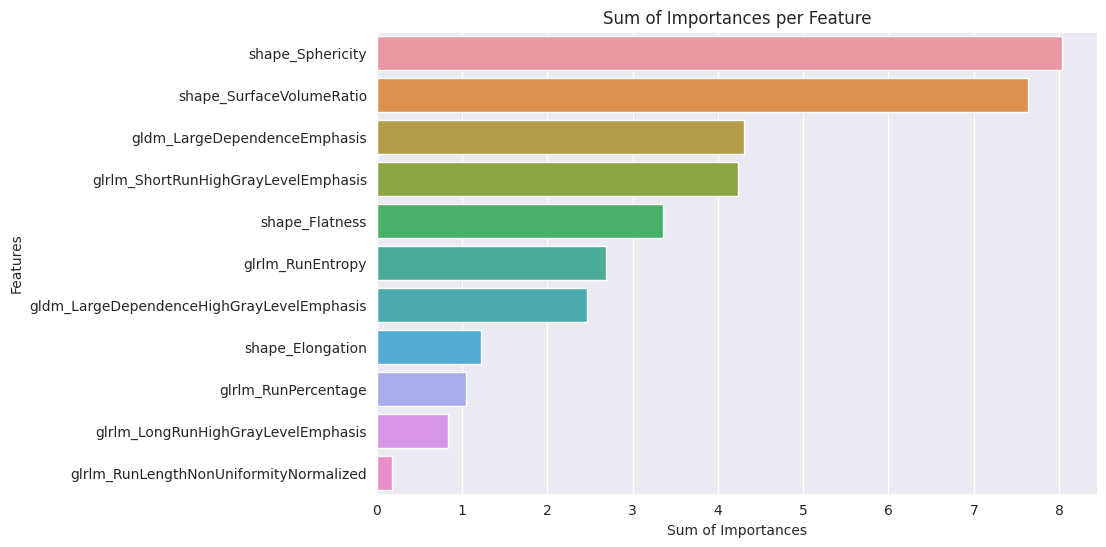

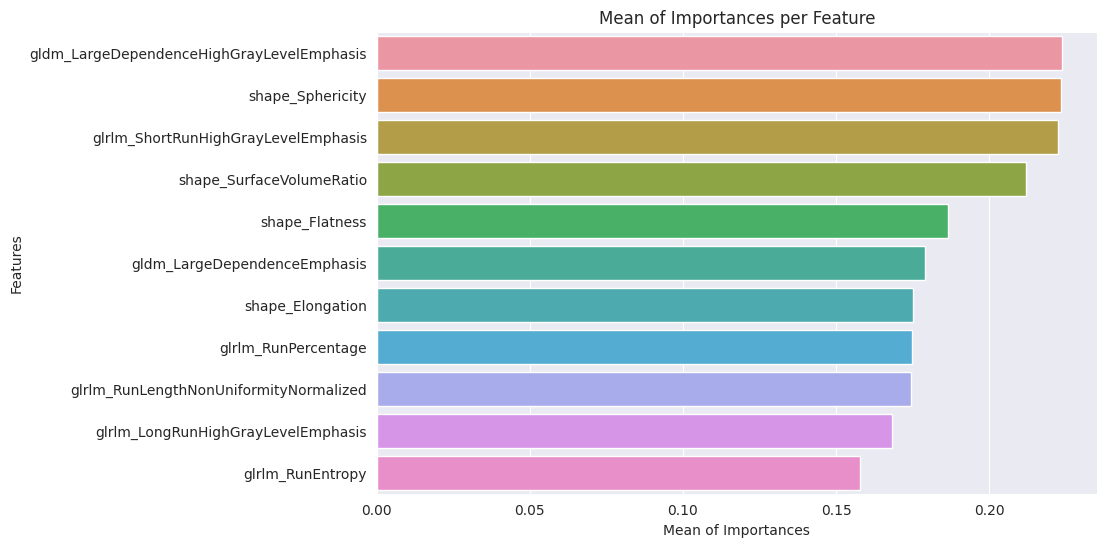

In [36]:

# Calculate the sum of importances per feature
feature_importance_sum = {}
for features, importance in best_features_RF:
    if features in feature_importance_sum:
        feature_importance_sum[features] += importance
    else:
        feature_importance_sum[features] = importance

# Convert the dictionary to lists for plotting
features = list(feature_importance_sum.keys())
importance_sum = list(feature_importance_sum.values())

# Sort the lists in descending order of importance_sum
sorted_indices = sorted(range(len(importance_sum)), key=lambda k: importance_sum[k], reverse=True)
features_sorted = [features[i] for i in sorted_indices]
importance_sum_sorted = [importance_sum[i] for i in sorted_indices]

# Plot the sum of importances per feature
plt.figure(figsize=(12, 6))
sns.barplot(x=importance_sum_sorted, y=features_sorted)
plt.xlabel('Sum of Importances')
plt.ylabel('Features')
plt.title('Sum of Importances per Feature')
plt.subplots_adjust(left=0.3)
plt.show()

feature_importance_mean = {}
feature_importance_sd = {}
feature_importance_ci = {}

for features, importance in best_features_RF:
    if features in feature_importance_mean:
        feature_importance_mean[features].append(importance)
    else:
        feature_importance_mean[features] = [importance]

feature_importance_mean_ = {feature: np.mean(importances) for feature, importances in feature_importance_mean.items()}
feature_importance_sd = {feature: np.std(importances) for feature, importances in feature_importance_mean.items()}

# Convert the dictionary to lists for plotting
features = list(feature_importance_mean_.keys())
importance_mean = list(feature_importance_mean_.values())

# Sort the lists in descending order of importance_mean
sorted_indices = sorted(range(len(importance_mean)), key=lambda k: importance_mean[k], reverse=True)
features_sorted = [features[i] for i in sorted_indices]
importance_mean_sorted = [importance_mean[i] for i in sorted_indices]

# Plot the mean of importances per feature
plt.figure(figsize=(12, 6))
sns.barplot(x=importance_mean_sorted, y=features_sorted)
plt.xlabel('Mean of Importances')
plt.ylabel('Features')
plt.title('Mean of Importances per Feature')

# Adjust the position of the figure
plt.subplots_adjust(left=0.3)

plt.show()

In [37]:

p_value_sum = {}
p_value_mean = {}
p_value_sd = {}

for p_value_dict in p_value:
    for feature, value in p_value_dict.items():
        if feature in p_value_sum:
            p_value_sum[feature] += value
        else:
            p_value_sum[feature] = value

# Calculate the mean and standard deviation of p-values per feature
for feature in p_value_sum:
    p_values_per_feature = [p_value_dict[feature] for p_value_dict in p_value if feature in p_value_dict]
    p_value_mean[feature] = np.mean(p_values_per_feature)
    p_value_sd[feature] = np.std(p_values_per_feature)

print('p_value_mean', p_value_mean)

p_value_mean {'shape_Sphericity': 1.6989878998720047e-08, 'shape_SurfaceVolumeRatio': 1.2641548606147338e-08, 'gldm_LargeDependenceEmphasis': 2.1931636482490153e-06, 'gldm_LargeDependenceHighGrayLevelEmphasis': 1.2641299806873257e-06, 'glrlm_ShortRunHighGrayLevelEmphasis': 1.1444280362793428e-06, 'glrlm_LongRunHighGrayLevelEmphasis': 1.6495402540591668e-07, 'glrlm_RunEntropy': 1.5120558689990403e-06, 'shape_Elongation': 1.1895155482270132e-06, 'shape_Flatness': 1.942431332578925e-06, 'glrlm_RunPercentage': 5.992796996565454e-07, 'glrlm_RunLengthNonUniformityNormalized': 8.088996741168106e-07}


## f 10

In [38]:
# Store the scores and metrics
scores_rf = {'acc': [], 'SD_acc': [], 'CI_acc': [], 'auc_tot': [], 'SD_auc_tot': [], 'CI_auc_tot': [], 'auc_class': [], 'SD_auc_class': [], 'CI_auc_class': [], 'Sen_mean': [], 'Sen_CI': [], 'Sen_SD': [], 'Spe_mean': [], 'Spe_CI': [], 'Spe_sd': []}
scores_svc = {'acc': [], 'SD_acc': [], 'CI_acc': [], 'auc_tot': [], 'SD_auc_tot': [], 'CI_auc_tot': [], 'auc_class': [], 'SD_auc_class': [], 'CI_auc_class': [], 'Sen_mean': [], 'Sen_CI':[], 'Sen_SD': [], 'Spe_mean': [], 'Spe_CI': [], 'Spe_sd': []}
best_features_RF = []
for name, pipeline in pipelines.items():
    # Initialize lists to store scores for each fold
    fold_acc = []
    fold_auc_tot = []
    fold_auc_class = []
    sensi = []
    speci = []
    features = []
    p_value = []
    feat = []
    value = []
    for train_index, test_index in cv_outer.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        scaler = StandardScaler()
        X_train_normed = scaler.fit_transform(X_train)
        X_test_normed = scaler.transform(X_test)

        X_train_scal = pd.DataFrame(X_train_normed, columns=X_train.columns, index=X_train.index)
        X_test_scal = pd.DataFrame(X_test_normed, columns=X_test.columns, index=X_test.index)

        #select the best 15 features
        selector = SelectKBest(f_classif, k=10) #20
        fit = selector.fit(X_train_scal, y_train)
        X_train_new = selector.fit_transform(X_train_scal, y_train)
        X_test_new = selector.transform(X_test_scal)
        selected_features_mask = selector.get_support()
        selected_feature_indices = [i for i, selected in enumerate(selected_features_mask)if selected]
        selected_feature_names = X.columns[selected_feature_indices]
        f_scores, p_values = f_classif(X_train_new, y_train)
        feature_p_values = dict(zip(selected_feature_names, p_values))
        p_value.append(feature_p_values)

        cv_inner = RepeatedStratifiedKFold(n_splits=4, n_repeats=4, random_state=seed)
        grid_search = GridSearchCV(pipeline, param_grids[name], cv=cv_inner, scoring='roc_auc_ovr', error_score="raise")
        grid_search.fit(X_train_new, y_train)
        #print(f'{name}', grid_search.best_score_)
        clf = grid_search.best_estimator_
        print(clf)
        clf.fit(X_train_new, y_train)
        y_pred = clf.predict(X_test_new)
        accuracy = accuracy_score(y_test, y_pred)
        #print("Accuracy:", f'{name}', accuracy)
        num_classes = len(np.unique(y_test))
        cm = confusion_matrix(y_test, y_pred)
        print(cm)
        specificity = calculate_specificity(cm)
        sensitivity = calculate_sensitivity(cm)
        # Print the results
        for i in range(num_classes):
            print(f"Class {i}")
            print(f" Training Specificity: {specificity[i]}")
            print(f" Training Sensitivity: {sensitivity[i]}")
            print()

        accuracy = accuracy_score(y_test, y_pred)
        fold_acc.append(accuracy)

        # Calculate AUC score
        auc_tot = multiclass_roc_auc_score(y_test, y_pred)
        fold_auc_tot.append(auc_tot)

        auc_class = class_vs_rest_roc_auc_score(y_test, y_pred)
        fold_auc_class.append(auc_class)

        speci.append(specificity)
        sensi.append(sensitivity)

        print('Auc Score', multiclass_roc_auc_score(y_test, y_pred))
        print('Auc Score OvR', class_vs_rest_roc_auc_score(y_test, y_pred))

        if name == 'rf':
            params_rf = grid_search.best_estimator_
            feature_importance = clf.named_steps['clf'].feature_importances_
            for featureses, importance in zip(selected_feature_names, feature_importance):
                best_features_RF.append((featureses, importance))
        else:
            continue
    # Calculate average scores across folds
    if name == 'rf':
        #acc
        avg_acc = np.mean(fold_acc)
        scores_rf['acc'].append(avg_acc)
        scores_rf['acc'] = scores_rf['acc'][-1]
        ci = stats.t.interval(confidence, len(fold_acc) - 1, loc=np.mean(fold_acc), scale=stats.sem(fold_acc))
        scores_rf['CI_acc'].append(ci)
        scores_rf['SD_acc'].append(np.std(fold_acc))

        #auc_tot
        avg_auc_tot = np.mean(fold_auc_tot)
        scores_rf['auc_tot'].append(avg_auc_tot)
        scores_rf['auc_tot'] = scores_rf['auc_tot'][-1]
        ci = stats.t.interval(confidence, len(fold_auc_tot) - 1, loc=np.mean(fold_auc_tot), scale=stats.sem(fold_auc_tot))
        scores_rf['CI_auc_tot'].append(ci)
        scores_rf['SD_auc_tot'].append(np.std(fold_acc))

        #auc_class
        list_0 = list(d[0] for d in fold_auc_class)
        list_1 = list(d[1] for d in fold_auc_class)
        list_2 = list(d[2] for d in fold_auc_class)

        avg_auc_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_rf['auc_class'].append(avg_auc_class)

        sd_auc_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_rf['SD_auc_class'].append(sd_auc_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_auc_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_rf['CI_auc_class'].append(CI_auc_class)

        #sensitivity
        list_0 = list(d[0] for d in sensi)
        list_1 = list(d[1] for d in sensi)
        list_2 = list(d[2] for d in sensi)

        avg_sensi_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_rf['Sen_mean'].append(avg_sensi_class)

        sd_sensi_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_rf['Sen_SD'].append(sd_sensi_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_sen_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_rf['Sen_CI'].append(CI_sen_class)

        #specificity
        list_0 = list(d[0] for d in speci)
        list_1 = list(d[1] for d in speci)
        list_2 = list(d[2] for d in speci)

        avg_speci_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_rf['Spe_mean'].append(avg_speci_class)
        sd_speci_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_rf['Spe_sd'].append(sd_speci_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_spe_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_rf['Spe_CI'].append(CI_spe_class)

    elif name == 'svc':
        # acc
        avg_acc = np.mean(fold_acc)
        scores_svc['acc'].append(avg_acc)
        scores_svc['acc'] = scores_svc['acc'][-1]
        ci = stats.t.interval(confidence, len(fold_acc) - 1, loc=np.mean(fold_acc), scale=stats.sem(fold_acc))
        scores_svc['CI_acc'].append(ci)
        scores_svc['SD_acc'].append(np.std(fold_acc))

        # auc_tot
        avg_auc_tot = np.mean(fold_auc_tot)
        scores_svc['auc_tot'].append(avg_auc_tot)
        scores_svc['auc_tot'] = scores_svc['auc_tot'][-1]
        ci = stats.t.interval(confidence, len(fold_auc_tot) - 1, loc=np.mean(fold_auc_tot), scale=stats.sem(fold_auc_tot))
        scores_svc['CI_auc_tot'].append(ci)
        scores_svc['SD_auc_tot'].append(np.std(fold_acc))

        # auc_class
        list_0 = list(d[0] for d in fold_auc_class)
        list_1 = list(d[1] for d in fold_auc_class)
        list_2 = list(d[2] for d in fold_auc_class)

        avg_auc_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_svc['auc_class'].append(avg_auc_class)

        sd_auc_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_svc['SD_auc_class'].append(sd_auc_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_auc_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_svc['CI_auc_class'].append(CI_auc_class)

        # sensitivity
        list_0 = list(d[0] for d in sensi)
        list_1 = list(d[1] for d in sensi)
        list_2 = list(d[2] for d in sensi)

        avg_sensi_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_svc['Sen_mean'].append(avg_sensi_class)

        sd_sensi_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_svc['Sen_SD'].append(sd_sensi_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_sen_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_svc['Sen_CI'].append(CI_sen_class)

        # specificity
        list_0 = list(d[0] for d in speci)
        list_1 = list(d[1] for d in speci)
        list_2 = list(d[2] for d in speci)

        avg_speci_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_svc['Spe_mean'].append(avg_speci_class)

        sd_speci_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_svc['Spe_sd'].append(sd_speci_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_spe_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_svc['Spe_CI'].append(CI_spe_class)

Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
[[ 5  0  2]
 [19 12 23]
 [ 2  2  8]]
Class 0
 Training Specificity: 68.18181818181817
 Training Sensitivity: 71.42857142857143

Class 1
 Training Specificity: 89.47368421052632
 Training Sensitivity: 22.22222222222222

Class 2
 Training Specificity: 59.01639344262295
 Training Sensitivity: 66.66666666666666

Auc Score 0.6283155935873795
Auc Score OvR {0: 0.6980519480519481, 1: 0.5584795321637427, 2: 0.628415300546448}
Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
[[ 4  1  2]
 [23 17 14]
 [ 2  4  6]]
Class 0
 Training Specificity: 62.121212121212125
 Training Sensitivity: 57.14285714285714

Class 

In [39]:

for name, score in scores_svc.items():
    print('svc', f'{name}: {score}')

for name, score in scores_rf.items():
    print('rf', f'{name}: {score}')

svc acc: 0.27321156773211563
svc SD_acc: [0.03694744625247597]
svc CI_acc: [(0.2605330193832534, 0.28589011608097786)]
svc auc_tot: 0.6197309343781667
svc SD_auc_tot: [0.03694744625247597]
svc CI_auc_tot: [(0.6034418663836856, 0.6360200023726479)]
svc auc_class: [{0: 0.6752950614890914, 1: 0.5191681633912406, 2: 0.6647295782541683}]
svc SD_auc_class: [{0: 0.1067497703966987, 1: 0.03357978955613982, 2: 0.07011977974358077}]
svc CI_auc_class: [{0: (0.6386637848385762, 0.7119263381396065), 1: (0.5076452293696881, 0.5306910974127931), 2: (0.6406679147872113, 0.6887912417211254)}]
svc Sen_mean: [{0: 77.11640211640213, 1: 10.229831508657506, 2: 72.66737891737891}]
svc Sen_CI: [{0: (70.35629043993791, 83.87651379286635), 1: (8.722814539614605, 11.736848477700407), 2: (67.76319576764391, 77.57156206711392)}]
svc Sen_SD: [{0: 19.70011518308493, 1: 4.391703760807801, 2: 14.29162380040087}]
svc Spe_mean: [{0: 57.94261018141614, 1: 93.60380116959065, 2: 60.27853673345477}]
svc Spe_CI: [{0: (55.750

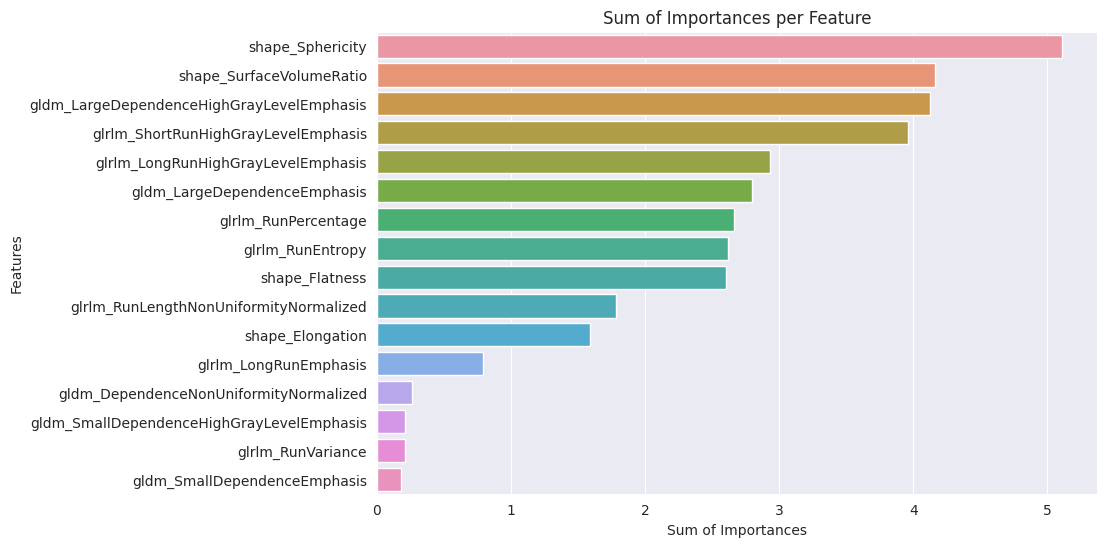

In [40]:

# Calculate the sum of importances per feature
feature_importance_sum = {}
for features, importance in best_features_RF:
    if features in feature_importance_sum:
        feature_importance_sum[features] += importance
    else:
        feature_importance_sum[features] = importance

# Convert the dictionary to lists for plotting
features = list(feature_importance_sum.keys())
importance_sum = list(feature_importance_sum.values())

# Sort the lists in descending order of importance_sum
sorted_indices = sorted(range(len(importance_sum)), key=lambda k: importance_sum[k], reverse=True)
features_sorted = [features[i] for i in sorted_indices]
importance_sum_sorted = [importance_sum[i] for i in sorted_indices]

# Plot the sum of importances per feature
plt.figure(figsize=(12, 6))
sns.barplot(x=importance_sum_sorted, y=features_sorted)
plt.xlabel('Sum of Importances')
plt.ylabel('Features')
plt.title('Sum of Importances per Feature')
plt.subplots_adjust(left=0.3)
plt.show()

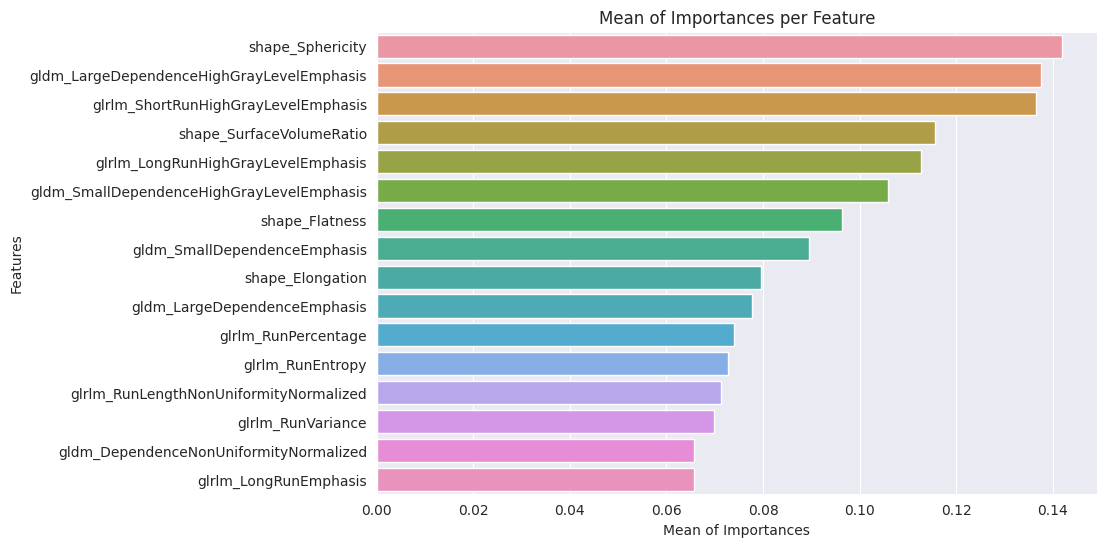

shape_Flatness [3.1681837007437103e-06, 4.5723686629954785e-07, 1.3319120227888977e-09, 2.7000043773648042e-05, 1.381428326110955e-08, 8.150264453793039e-07, 3.366721595794258e-06, 2.0387183431735677e-07, 3.978712057346953e-08, 1.0838820849672241e-07, 3.975216141825922e-06, 1.6409278477766546e-08, 2.376151579975992e-05, 5.831164368125094e-06, 9.652376660415758e-09, 9.940991527367603e-05, 7.03085340121805e-10, 1.0000816250839635e-05, 4.95439862329191e-08, 1.1866991117007249e-07, 1.172272643684535e-06, 5.028751912124116e-08, 5.322705821727334e-08, 3.7481158018093134e-07, 6.93485869993617e-06, 1.7971440255144362e-06, 7.07341795828475e-07]
shape_Sphericity [7.340024810748706e-10, 1.5852055096110667e-10, 4.845232619846369e-10, 5.978344593597296e-10, 1.0573969191123729e-11, 1.3249754906121298e-07, 3.6358882930484856e-09, 3.27702239125033e-09, 4.828923723511336e-11, 4.00769244115798e-08, 9.051715321386993e-10, 5.624247403668833e-12, 2.83723355425192e-12, 3.2590845656020095e-09, 1.132642282731

In [41]:

feature_importance_mean = {}
feature_importance_sd = {}
feature_importance_ci = {}

for features, importance in best_features_RF:
    if features in feature_importance_mean:
        feature_importance_mean[features].append(importance)
    else:
        feature_importance_mean[features] = [importance]

feature_importance_mean_ = {feature: np.mean(importances) for feature, importances in feature_importance_mean.items()}
feature_importance_sd = {feature: np.std(importances) for feature, importances in feature_importance_mean.items()}

# Convert the dictionary to lists for plotting
features = list(feature_importance_mean_.keys())
importance_mean = list(feature_importance_mean_.values())

# Sort the lists in descending order of importance_mean
sorted_indices = sorted(range(len(importance_mean)), key=lambda k: importance_mean[k], reverse=True)
features_sorted = [features[i] for i in sorted_indices]
importance_mean_sorted = [importance_mean[i] for i in sorted_indices]

# Plot the mean of importances per feature
plt.figure(figsize=(12, 6))
sns.barplot(x=importance_mean_sorted, y=features_sorted)
plt.xlabel('Mean of Importances')
plt.ylabel('Features')
plt.title('Mean of Importances per Feature')

# Adjust the position of the figure
plt.subplots_adjust(left=0.3)

plt.show()

p_value_sum = {}
p_value_mean = {}
p_value_sd = {}

for p_value_dict in p_value:
    for feature, value in p_value_dict.items():
        if feature in p_value_sum:
            p_value_sum[feature] += value
        else:
            p_value_sum[feature] = value

# Calculate the mean and standard deviation of p-values per feature
for feature in p_value_sum:
    p_values_per_feature = [p_value_dict[feature] for p_value_dict in p_value if feature in p_value_dict]
    print(f'{feature}', f'{p_values_per_feature}')
    p_value_mean[feature] = np.mean(p_values_per_feature)
    p_value_sd[feature] = np.std(p_values_per_feature)

print('p_value_sum', p_value_sum)
print('p_value_mean', p_value_mean)
print('p_value_sd', p_value_sd)

## f 15

In [42]:
# Store the scores and metrics
scores_rf = {'acc': [], 'SD_acc': [], 'CI_acc': [], 'auc_tot': [], 'SD_auc_tot': [], 'CI_auc_tot': [], 'auc_class': [], 'SD_auc_class': [], 'CI_auc_class': [], 'Sen_mean': [], 'Sen_CI': [], 'Sen_SD': [], 'Spe_mean': [], 'Spe_CI': [], 'Spe_sd': []}
scores_svc = {'acc': [], 'SD_acc': [], 'CI_acc': [], 'auc_tot': [], 'SD_auc_tot': [], 'CI_auc_tot': [], 'auc_class': [], 'SD_auc_class': [], 'CI_auc_class': [], 'Sen_mean': [], 'Sen_CI':[], 'Sen_SD': [], 'Spe_mean': [], 'Spe_CI': [], 'Spe_sd': []}
best_features_RF = []
for name, pipeline in pipelines.items():
    # Initialize lists to store scores for each fold
    fold_acc = []
    fold_auc_tot = []
    fold_auc_class = []
    sensi = []
    speci = []
    features = []
    p_value = []
    feat = []
    value = []
    for train_index, test_index in cv_outer.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        scaler = StandardScaler()
        X_train_normed = scaler.fit_transform(X_train)
        X_test_normed = scaler.transform(X_test)

        X_train_scal = pd.DataFrame(X_train_normed, columns=X_train.columns, index=X_train.index)
        X_test_scal = pd.DataFrame(X_test_normed, columns=X_test.columns, index=X_test.index)

        #select the best 15 features
        selector = SelectKBest(f_classif, k=15) #20
        fit = selector.fit(X_train_scal, y_train)
        X_train_new = selector.fit_transform(X_train_scal, y_train)
        X_test_new = selector.transform(X_test_scal)
        selected_features_mask = selector.get_support()
        selected_feature_indices = [i for i, selected in enumerate(selected_features_mask)if selected]
        selected_feature_names = X.columns[selected_feature_indices]
        f_scores, p_values = f_classif(X_train_new, y_train)
        feature_p_values = dict(zip(selected_feature_names, p_values))
        p_value.append(feature_p_values)

        cv_inner = RepeatedStratifiedKFold(n_splits=4, n_repeats=4, random_state=seed)
        grid_search = GridSearchCV(pipeline, param_grids[name], cv=cv_inner, scoring='roc_auc_ovr', error_score="raise")
        grid_search.fit(X_train_new, y_train)
        clf = grid_search.best_estimator_
        print(clf)
        clf.fit(X_train_new, y_train)
        y_pred = clf.predict(X_test_new)
        accuracy = accuracy_score(y_test, y_pred)
        num_classes = len(np.unique(y_test))
        cm = confusion_matrix(y_test, y_pred)
        specificity = calculate_specificity(cm)
        sensitivity = calculate_sensitivity(cm)
        # Print the results
        for i in range(num_classes):
            print(f"Class {i}")
            print(f" Training Specificity: {specificity[i]}")
            print(f" Training Sensitivity: {sensitivity[i]}")
            print()

        accuracy = accuracy_score(y_test, y_pred)
        fold_acc.append(accuracy)

        # Calculate AUC score
        auc_tot = multiclass_roc_auc_score(y_test, y_pred)
        fold_auc_tot.append(auc_tot)

        auc_class = class_vs_rest_roc_auc_score(y_test, y_pred)
        fold_auc_class.append(auc_class)

        speci.append(specificity)
        sensi.append(sensitivity)

        print('Auc Score', multiclass_roc_auc_score(y_test, y_pred))
        print('Auc Score OvR', class_vs_rest_roc_auc_score(y_test, y_pred))

        if name == 'rf':
            params_rf = grid_search.best_estimator_
            feature_importance = clf.named_steps['clf'].feature_importances_
            for featureses, importance in zip(selected_feature_names, feature_importance):
                best_features_RF.append((featureses, importance))
        else:
            continue
    # Calculate average scores across folds
    if name == 'rf':
        #acc
        avg_acc = np.mean(fold_acc)
        scores_rf['acc'].append(avg_acc)
        scores_rf['acc'] = scores_rf['acc'][-1]
        ci = stats.t.interval(confidence, len(fold_acc) - 1, loc=np.mean(fold_acc), scale=stats.sem(fold_acc))
        scores_rf['CI_acc'].append(ci)
        scores_rf['SD_acc'].append(np.std(fold_acc))

        #auc_tot
        avg_auc_tot = np.mean(fold_auc_tot)
        scores_rf['auc_tot'].append(avg_auc_tot)
        scores_rf['auc_tot'] = scores_rf['auc_tot'][-1]
        ci = stats.t.interval(confidence, len(fold_auc_tot) - 1, loc=np.mean(fold_auc_tot), scale=stats.sem(fold_auc_tot))
        scores_rf['CI_auc_tot'].append(ci)
        scores_rf['SD_auc_tot'].append(np.std(fold_acc))

        #auc_class
        list_0 = list(d[0] for d in fold_auc_class)
        list_1 = list(d[1] for d in fold_auc_class)
        list_2 = list(d[2] for d in fold_auc_class)

        avg_auc_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_rf['auc_class'].append(avg_auc_class)

        sd_auc_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_rf['SD_auc_class'].append(sd_auc_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_auc_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_rf['CI_auc_class'].append(CI_auc_class)

        #sensitivity
        list_0 = list(d[0] for d in sensi)
        list_1 = list(d[1] for d in sensi)
        list_2 = list(d[2] for d in sensi)

        avg_sensi_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_rf['Sen_mean'].append(avg_sensi_class)

        sd_sensi_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_rf['Sen_SD'].append(sd_sensi_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_sen_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_rf['Sen_CI'].append(CI_sen_class)

        #specificity
        list_0 = list(d[0] for d in speci)
        list_1 = list(d[1] for d in speci)
        list_2 = list(d[2] for d in speci)

        avg_speci_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_rf['Spe_mean'].append(avg_speci_class)
        sd_speci_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_rf['Spe_sd'].append(sd_speci_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_spe_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_rf['Spe_CI'].append(CI_spe_class)

    elif name == 'svc':
        # acc
        avg_acc = np.mean(fold_acc)
        scores_svc['acc'].append(avg_acc)
        scores_svc['acc'] = scores_svc['acc'][-1]
        ci = stats.t.interval(confidence, len(fold_acc) - 1, loc=np.mean(fold_acc), scale=stats.sem(fold_acc))
        scores_svc['CI_acc'].append(ci)
        scores_svc['SD_acc'].append(np.std(fold_acc))

        # auc_tot
        avg_auc_tot = np.mean(fold_auc_tot)
        scores_svc['auc_tot'].append(avg_auc_tot)
        scores_svc['auc_tot'] = scores_svc['auc_tot'][-1]
        ci = stats.t.interval(confidence, len(fold_auc_tot) - 1, loc=np.mean(fold_auc_tot), scale=stats.sem(fold_auc_tot))
        scores_svc['CI_auc_tot'].append(ci)
        scores_svc['SD_auc_tot'].append(np.std(fold_acc))

        # auc_class
        list_0 = list(d[0] for d in fold_auc_class)
        list_1 = list(d[1] for d in fold_auc_class)
        list_2 = list(d[2] for d in fold_auc_class)

        avg_auc_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_svc['auc_class'].append(avg_auc_class)

        sd_auc_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_svc['SD_auc_class'].append(sd_auc_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_auc_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_svc['CI_auc_class'].append(CI_auc_class)

        # sensitivity
        list_0 = list(d[0] for d in sensi)
        list_1 = list(d[1] for d in sensi)
        list_2 = list(d[2] for d in sensi)

        avg_sensi_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_svc['Sen_mean'].append(avg_sensi_class)

        sd_sensi_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_svc['Sen_SD'].append(sd_sensi_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_sen_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_svc['Sen_CI'].append(CI_sen_class)

        # specificity
        list_0 = list(d[0] for d in speci)
        list_1 = list(d[1] for d in speci)
        list_2 = list(d[2] for d in speci)

        avg_speci_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_svc['Spe_mean'].append(avg_speci_class)

        sd_speci_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_svc['Spe_sd'].append(sd_speci_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_spe_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_svc['Spe_CI'].append(CI_spe_class)

Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Class 0
 Training Specificity: 71.21212121212122
 Training Sensitivity: 57.14285714285714

Class 1
 Training Specificity: 94.73684210526315
 Training Sensitivity: 22.22222222222222

Class 2
 Training Specificity: 54.09836065573771
 Training Sensitivity: 75.0

Auc Score 0.6240206722303357
Auc Score OvR {0: 0.6417748917748918, 1: 0.5847953216374271, 2: 0.6454918032786885}
Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Class 0
 Training Specificity: 60.60606060606061
 Training Sensitivity: 71.42857142857143

Class 1
 Training Specificity: 94.73684210526315
 Training Sensitivity: 16.666666666666664



In [43]:

for name, score in scores_svc.items():
    print('svc', f'{name}: {score}')

for name, score in scores_rf.items():
    print('rf', f'{name}: {score}')

svc acc: 0.27587519025875185
svc SD_acc: [0.036408586072215456]
svc CI_acc: [(0.2633815522498905, 0.2883688282676132)]
svc auc_tot: 0.6274350259978888
svc SD_auc_tot: [0.036408586072215456]
svc CI_auc_tot: [(0.6143589467114726, 0.640511105284305)]
svc auc_class: [{0: 0.6932060476836595, 1: 0.5123782442654505, 2: 0.6767207860445565}]
svc SD_auc_class: [{0: 0.09470545593748483, 1: 0.03338346508143524, 2: 0.07052494789900936}]
svc CI_auc_class: [{0: (0.66070778802589, 0.7257043073414289), 1: (0.5009226791583177, 0.5238338093725834), 2: (0.6525200887723152, 0.7009214833167979)}]
svc Sen_mean: [{0: 80.02645502645504, 1: 9.602841835546238, 2: 75.24928774928777}]
svc Sen_CI: [{0: (73.77361830252258, 86.2792917503875), 1: (7.823834108497989, 11.381849562594487), 2: (70.56285202133773, 79.93572347723781)}]
svc Sen_SD: [{0: 18.22182969422796, 1: 5.184331089746026, 2: 13.6570707789}]
svc Spe_mean: [{0: 58.6147545102769, 1: 92.87280701754385, 2: 60.094869459623546}]
svc Spe_CI: [{0: (56.1943072412

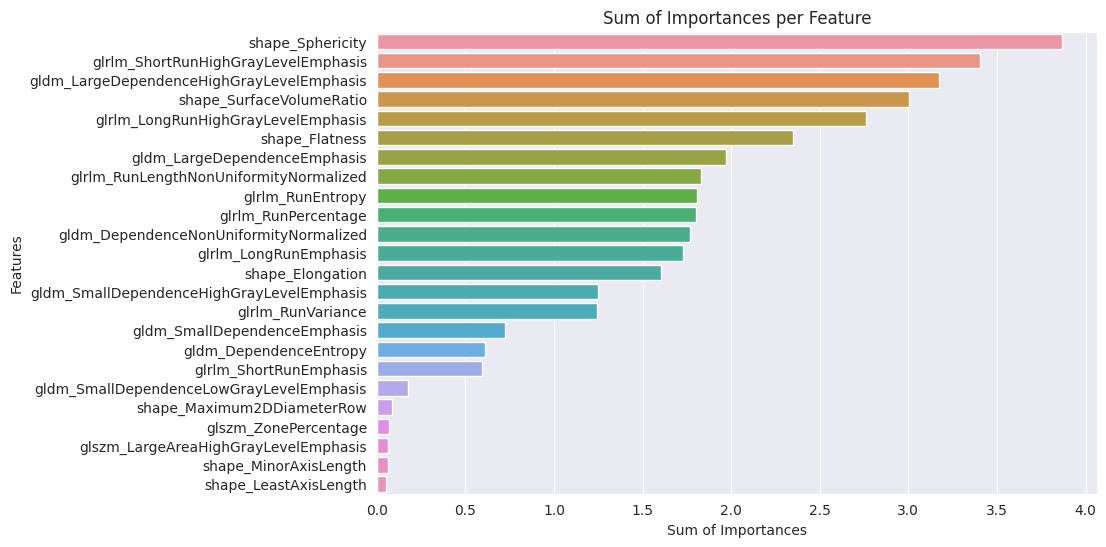

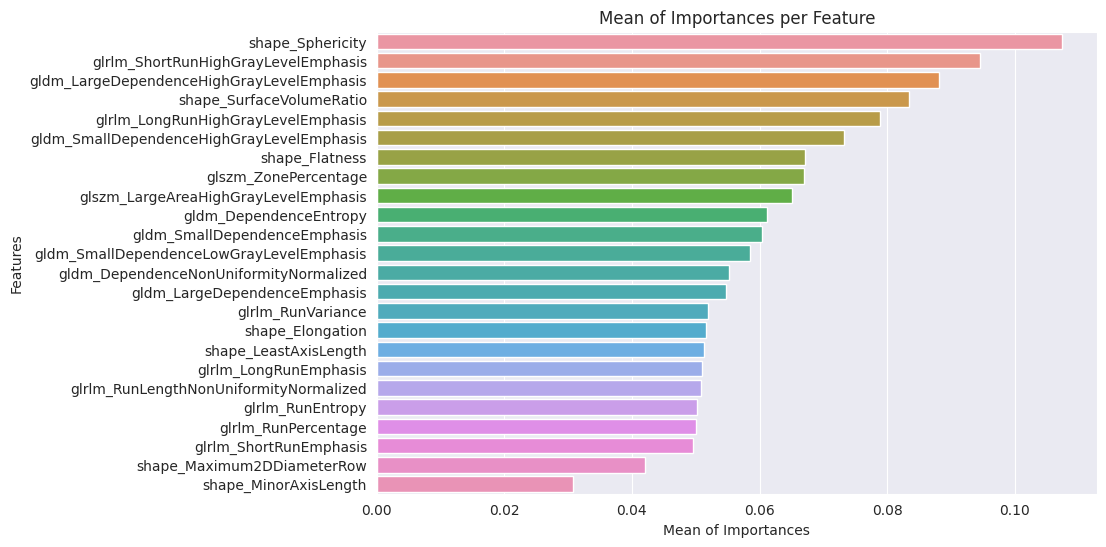

In [44]:

# Calculate the sum of importances per feature
feature_importance_sum = {}
for features, importance in best_features_RF:
    if features in feature_importance_sum:
        feature_importance_sum[features] += importance
    else:
        feature_importance_sum[features] = importance

# Convert the dictionary to lists for plotting
features = list(feature_importance_sum.keys())
importance_sum = list(feature_importance_sum.values())

# Sort the lists in descending order of importance_sum
sorted_indices = sorted(range(len(importance_sum)), key=lambda k: importance_sum[k], reverse=True)
features_sorted = [features[i] for i in sorted_indices]
importance_sum_sorted = [importance_sum[i] for i in sorted_indices]

# Plot the sum of importances per feature
plt.figure(figsize=(12, 6))
sns.barplot(x=importance_sum_sorted, y=features_sorted)
plt.xlabel('Sum of Importances')
plt.ylabel('Features')
plt.title('Sum of Importances per Feature')
plt.subplots_adjust(left=0.3)
plt.show()

feature_importance_mean = {}
feature_importance_sd = {}
feature_importance_ci = {}

for features, importance in best_features_RF:
    if features in feature_importance_mean:
        feature_importance_mean[features].append(importance)
    else:
        feature_importance_mean[features] = [importance]

feature_importance_mean_ = {feature: np.mean(importances) for feature, importances in feature_importance_mean.items()}
feature_importance_sd = {feature: np.std(importances) for feature, importances in feature_importance_mean.items()}

# Convert the dictionary to lists for plotting
features = list(feature_importance_mean_.keys())
importance_mean = list(feature_importance_mean_.values())

# Sort the lists in descending order of importance_mean
sorted_indices = sorted(range(len(importance_mean)), key=lambda k: importance_mean[k], reverse=True)
features_sorted = [features[i] for i in sorted_indices]
importance_mean_sorted = [importance_mean[i] for i in sorted_indices]

# Plot the mean of importances per feature
plt.figure(figsize=(12, 6))
sns.barplot(x=importance_mean_sorted, y=features_sorted)
plt.xlabel('Mean of Importances')
plt.ylabel('Features')
plt.title('Mean of Importances per Feature')

# Adjust the position of the figure
plt.subplots_adjust(left=0.3)

plt.show()

In [45]:

p_value_sum = {}
p_value_mean = {}
p_value_sd = {}

for p_value_dict in p_value:
    for feature, value in p_value_dict.items():
        if feature in p_value_sum:
            p_value_sum[feature] += value
        else:
            p_value_sum[feature] = value

# Calculate the mean and standard deviation of p-values per feature
for feature in p_value_sum:
    p_values_per_feature = [p_value_dict[feature] for p_value_dict in p_value if feature in p_value_dict]
    p_value_mean[feature] = np.mean(p_values_per_feature)
    p_value_sd[feature] = np.std(p_values_per_feature)

print('p_value_mean', p_value_mean)

p_value_mean {'shape_Elongation': 3.089994462219894e-05, 'shape_Flatness': 2.0652149922569695e-05, 'shape_Sphericity': 1.6989878998720047e-08, 'shape_SurfaceVolumeRatio': 1.2641548606147338e-08, 'gldm_DependenceNonUniformityNormalized': 0.0001170286193670908, 'gldm_LargeDependenceEmphasis': 2.796487864389888e-06, 'gldm_LargeDependenceHighGrayLevelEmphasis': 7.1712495345269785e-06, 'glrlm_LongRunEmphasis': 8.223970012727328e-05, 'glrlm_LongRunHighGrayLevelEmphasis': 4.905267435102275e-05, 'glrlm_RunEntropy': 4.9185602608819765e-06, 'glrlm_RunLengthNonUniformityNormalized': 1.2648778291153216e-05, 'glrlm_RunPercentage': 6.281361669995924e-06, 'glrlm_RunVariance': 5.629444229098737e-05, 'glrlm_ShortRunEmphasis': 0.0002008743188703957, 'glrlm_ShortRunHighGrayLevelEmphasis': 2.868037669812981e-06, 'gldm_DependenceEntropy': 8.767075500267383e-05, 'gldm_SmallDependenceHighGrayLevelEmphasis': 0.0002026674155298386, 'gldm_SmallDependenceEmphasis': 0.0002683288971503897, 'gldm_SmallDependenceLow

## f 20

In [46]:
# Store the scores and metrics
scores_rf = {'acc': [], 'SD_acc': [], 'CI_acc': [], 'auc_tot': [], 'SD_auc_tot': [], 'CI_auc_tot': [], 'auc_class': [], 'SD_auc_class': [], 'CI_auc_class': [], 'Sen_mean': [], 'Sen_CI': [], 'Sen_SD': [], 'Spe_mean': [], 'Spe_CI': [], 'Spe_sd': []}
scores_svc = {'acc': [], 'SD_acc': [], 'CI_acc': [], 'auc_tot': [], 'SD_auc_tot': [], 'CI_auc_tot': [], 'auc_class': [], 'SD_auc_class': [], 'CI_auc_class': [], 'Sen_mean': [], 'Sen_CI':[], 'Sen_SD': [], 'Spe_mean': [], 'Spe_CI': [], 'Spe_sd': []}
best_features_RF = []
for name, pipeline in pipelines.items():
    # Initialize lists to store scores for each fold
    fold_acc = []
    fold_auc_tot = []
    fold_auc_class = []
    sensi = []
    speci = []
    features = []
    p_value = []
    feat = []
    value = []
    for train_index, test_index in cv_outer.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        scaler = StandardScaler()
        X_train_normed = scaler.fit_transform(X_train)
        X_test_normed = scaler.transform(X_test)

        X_train_scal = pd.DataFrame(X_train_normed, columns=X_train.columns, index=X_train.index)
        X_test_scal = pd.DataFrame(X_test_normed, columns=X_test.columns, index=X_test.index)

        #select the best 15 features
        selector = SelectKBest(f_classif, k=20) #20
        fit = selector.fit(X_train_scal, y_train)
        X_train_new = selector.fit_transform(X_train_scal, y_train)
        X_test_new = selector.transform(X_test_scal)
        selected_features_mask = selector.get_support()
        selected_feature_indices = [i for i, selected in enumerate(selected_features_mask)if selected]
        selected_feature_names = X.columns[selected_feature_indices]
        f_scores, p_values = f_classif(X_train_new, y_train)
        feature_p_values = dict(zip(selected_feature_names, p_values))
        p_value.append(feature_p_values)

        cv_inner = RepeatedStratifiedKFold(n_splits=4, n_repeats=4, random_state=seed)
        grid_search = GridSearchCV(pipeline, param_grids[name], cv=cv_inner, scoring='roc_auc_ovr', error_score="raise")
        grid_search.fit(X_train_new, y_train)
        clf = grid_search.best_estimator_
        print(clf)
        clf.fit(X_train_new, y_train)
        y_pred = clf.predict(X_test_new)
        accuracy = accuracy_score(y_test, y_pred)
        num_classes = len(np.unique(y_test))
        cm = confusion_matrix(y_test, y_pred)
        specificity = calculate_specificity(cm)
        sensitivity = calculate_sensitivity(cm)
        # Print the results
        for i in range(num_classes):
            print(f"Class {i}")
            print(f" Training Specificity: {specificity[i]}")
            print(f" Training Sensitivity: {sensitivity[i]}")
            print()

        accuracy = accuracy_score(y_test, y_pred)
        fold_acc.append(accuracy)

        # Calculate AUC score
        auc_tot = multiclass_roc_auc_score(y_test, y_pred)
        fold_auc_tot.append(auc_tot)

        auc_class = class_vs_rest_roc_auc_score(y_test, y_pred)
        fold_auc_class.append(auc_class)

        speci.append(specificity)
        sensi.append(sensitivity)

        print('Auc Score', multiclass_roc_auc_score(y_test, y_pred))
        print('Auc Score OvR', class_vs_rest_roc_auc_score(y_test, y_pred))

        if name == 'rf':
            params_rf = grid_search.best_estimator_
            feature_importance = clf.named_steps['clf'].feature_importances_
            for featureses, importance in zip(selected_feature_names, feature_importance):
                best_features_RF.append((featureses, importance))
        else:
            continue
    # Calculate average scores across folds
    if name == 'rf':
        #acc
        avg_acc = np.mean(fold_acc)
        scores_rf['acc'].append(avg_acc)
        scores_rf['acc'] = scores_rf['acc'][-1]
        ci = stats.t.interval(confidence, len(fold_acc) - 1, loc=np.mean(fold_acc), scale=stats.sem(fold_acc))
        scores_rf['CI_acc'].append(ci)
        scores_rf['SD_acc'].append(np.std(fold_acc))

        #auc_tot
        avg_auc_tot = np.mean(fold_auc_tot)
        scores_rf['auc_tot'].append(avg_auc_tot)
        scores_rf['auc_tot'] = scores_rf['auc_tot'][-1]
        ci = stats.t.interval(confidence, len(fold_auc_tot) - 1, loc=np.mean(fold_auc_tot), scale=stats.sem(fold_auc_tot))
        scores_rf['CI_auc_tot'].append(ci)
        scores_rf['SD_auc_tot'].append(np.std(fold_acc))

        #auc_class
        list_0 = list(d[0] for d in fold_auc_class)
        list_1 = list(d[1] for d in fold_auc_class)
        list_2 = list(d[2] for d in fold_auc_class)

        avg_auc_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_rf['auc_class'].append(avg_auc_class)

        sd_auc_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_rf['SD_auc_class'].append(sd_auc_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_auc_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_rf['CI_auc_class'].append(CI_auc_class)

        #sensitivity
        list_0 = list(d[0] for d in sensi)
        list_1 = list(d[1] for d in sensi)
        list_2 = list(d[2] for d in sensi)

        avg_sensi_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_rf['Sen_mean'].append(avg_sensi_class)

        sd_sensi_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_rf['Sen_SD'].append(sd_sensi_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_sen_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_rf['Sen_CI'].append(CI_sen_class)

        #specificity
        list_0 = list(d[0] for d in speci)
        list_1 = list(d[1] for d in speci)
        list_2 = list(d[2] for d in speci)

        avg_speci_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_rf['Spe_mean'].append(avg_speci_class)
        sd_speci_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_rf['Spe_sd'].append(sd_speci_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_spe_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_rf['Spe_CI'].append(CI_spe_class)

    elif name == 'svc':
        # acc
        avg_acc = np.mean(fold_acc)
        scores_svc['acc'].append(avg_acc)
        scores_svc['acc'] = scores_svc['acc'][-1]
        ci = stats.t.interval(confidence, len(fold_acc) - 1, loc=np.mean(fold_acc), scale=stats.sem(fold_acc))
        scores_svc['CI_acc'].append(ci)
        scores_svc['SD_acc'].append(np.std(fold_acc))

        # auc_tot
        avg_auc_tot = np.mean(fold_auc_tot)
        scores_svc['auc_tot'].append(avg_auc_tot)
        scores_svc['auc_tot'] = scores_svc['auc_tot'][-1]
        ci = stats.t.interval(confidence, len(fold_auc_tot) - 1, loc=np.mean(fold_auc_tot), scale=stats.sem(fold_auc_tot))
        scores_svc['CI_auc_tot'].append(ci)
        scores_svc['SD_auc_tot'].append(np.std(fold_acc))

        # auc_class
        list_0 = list(d[0] for d in fold_auc_class)
        list_1 = list(d[1] for d in fold_auc_class)
        list_2 = list(d[2] for d in fold_auc_class)

        avg_auc_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_svc['auc_class'].append(avg_auc_class)

        sd_auc_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_svc['SD_auc_class'].append(sd_auc_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_auc_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_svc['CI_auc_class'].append(CI_auc_class)

        # sensitivity
        list_0 = list(d[0] for d in sensi)
        list_1 = list(d[1] for d in sensi)
        list_2 = list(d[2] for d in sensi)

        avg_sensi_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_svc['Sen_mean'].append(avg_sensi_class)

        sd_sensi_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_svc['Sen_SD'].append(sd_sensi_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_sen_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_svc['Sen_CI'].append(CI_sen_class)

        # specificity
        list_0 = list(d[0] for d in speci)
        list_1 = list(d[1] for d in speci)
        list_2 = list(d[2] for d in speci)

        avg_speci_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_svc['Spe_mean'].append(avg_speci_class)

        sd_speci_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_svc['Spe_sd'].append(sd_speci_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_spe_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_svc['Spe_CI'].append(CI_spe_class)

Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Class 0
 Training Specificity: 63.63636363636363
 Training Sensitivity: 71.42857142857143

Class 1
 Training Specificity: 89.47368421052632
 Training Sensitivity: 22.22222222222222

Class 2
 Training Specificity: 65.57377049180327
 Training Sensitivity: 75.0

Auc Score 0.6455576866491449
Auc Score OvR {0: 0.6753246753246754, 1: 0.5584795321637427, 2: 0.7028688524590165}
Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Class 0
 Training Specificity: 59.09090909090909
 Training Sensitivity: 71.42857142857143

Class 1
 Training Specificity: 89.47368421052632
 Training Sensitivity: 16.666666666666664



In [47]:

for name, score in scores_svc.items():
    print('svc', f'{name}: {score}')

for name, score in scores_rf.items():
    print('rf', f'{name}: {score}')

svc acc: 0.2754946727549467
svc SD_acc: [0.038309628458609496]
svc CI_acc: [(0.26234869039610154, 0.2886406551137919)]
svc auc_tot: 0.6139629237798833
svc SD_auc_tot: [0.038309628458609496]
svc CI_auc_tot: [(0.6014444886762309, 0.6264813588835356)]
svc auc_class: [{0: 0.6701467410422633, 1: 0.5099034893604847, 2: 0.6618385409369015}]
svc SD_auc_class: [{0: 0.0936028680834334, 1: 0.03418708946797879, 2: 0.058534907121359066}]
svc CI_auc_class: [{0: (0.6380268353665509, 0.7022666467179758), 1: (0.4981721598454549, 0.5216348188755144), 2: (0.6417522365963254, 0.6819248452774777)}]
svc Sen_mean: [{0: 75.46296296296298, 1: 10.949996117711004, 2: 71.67022792022792}]
svc Sen_CI: [{0: (68.94146915786952, 81.98445676805643), 1: (9.02401877274033, 12.875973462681678), 2: (67.6935811705161, 75.64687466993973)}]
svc Sen_SD: [{0: 19.0047421218509, 1: 5.612625552922721, 2: 11.588624975606601}]
svc Spe_mean: [{0: 58.56638524548972, 1: 91.03070175438596, 2: 60.6974802671524}]
svc Spe_CI: [{0: (56.1449

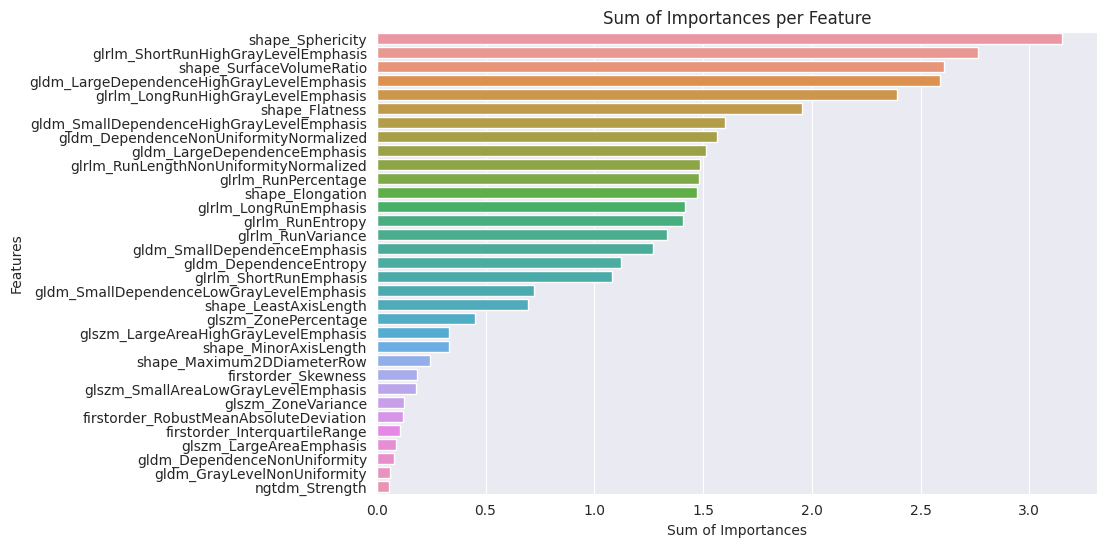

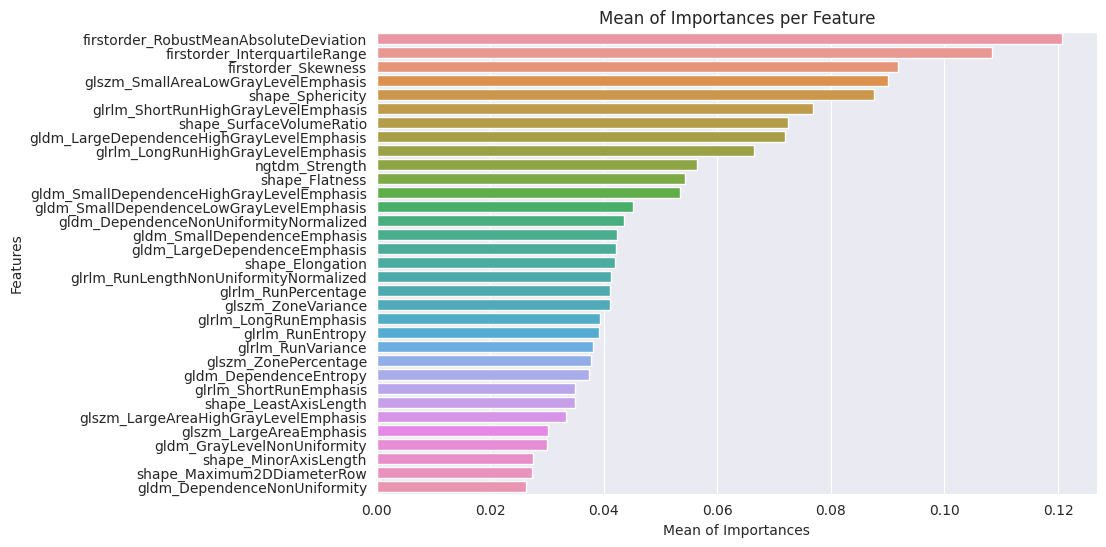

In [48]:

# Calculate the sum of importances per feature
feature_importance_sum = {}
for features, importance in best_features_RF:
    if features in feature_importance_sum:
        feature_importance_sum[features] += importance
    else:
        feature_importance_sum[features] = importance

# Convert the dictionary to lists for plotting
features = list(feature_importance_sum.keys())
importance_sum = list(feature_importance_sum.values())

# Sort the lists in descending order of importance_sum
sorted_indices = sorted(range(len(importance_sum)), key=lambda k: importance_sum[k], reverse=True)
features_sorted = [features[i] for i in sorted_indices]
importance_sum_sorted = [importance_sum[i] for i in sorted_indices]

# Plot the sum of importances per feature
plt.figure(figsize=(12, 6))
sns.barplot(x=importance_sum_sorted, y=features_sorted)
plt.xlabel('Sum of Importances')
plt.ylabel('Features')
plt.title('Sum of Importances per Feature')
plt.subplots_adjust(left=0.3)
plt.show()

feature_importance_mean = {}
feature_importance_sd = {}
feature_importance_ci = {}

for features, importance in best_features_RF:
    if features in feature_importance_mean:
        feature_importance_mean[features].append(importance)
    else:
        feature_importance_mean[features] = [importance]

feature_importance_mean_ = {feature: np.mean(importances) for feature, importances in feature_importance_mean.items()}
feature_importance_sd = {feature: np.std(importances) for feature, importances in feature_importance_mean.items()}

# Convert the dictionary to lists for plotting
features = list(feature_importance_mean_.keys())
importance_mean = list(feature_importance_mean_.values())

# Sort the lists in descending order of importance_mean
sorted_indices = sorted(range(len(importance_mean)), key=lambda k: importance_mean[k], reverse=True)
features_sorted = [features[i] for i in sorted_indices]
importance_mean_sorted = [importance_mean[i] for i in sorted_indices]

# Plot the mean of importances per feature
plt.figure(figsize=(12, 6))
sns.barplot(x=importance_mean_sorted, y=features_sorted)
plt.xlabel('Mean of Importances')
plt.ylabel('Features')
plt.title('Mean of Importances per Feature')

# Adjust the position of the figure
plt.subplots_adjust(left=0.3)

plt.show()

In [49]:

p_value_sum = {}
p_value_mean = {}
p_value_sd = {}

for p_value_dict in p_value:
    for feature, value in p_value_dict.items():
        if feature in p_value_sum:
            p_value_sum[feature] += value
        else:
            p_value_sum[feature] = value

# Calculate the mean and standard deviation of p-values per feature
for feature in p_value_sum:
    p_values_per_feature = [p_value_dict[feature] for p_value_dict in p_value if feature in p_value_dict]
    p_value_mean[feature] = np.mean(p_values_per_feature)
    p_value_sd[feature] = np.std(p_values_per_feature)

print('p_value_mean', p_value_mean)

p_value_mean {'shape_Elongation': 3.818913299729305e-05, 'shape_Flatness': 2.4351297447469278e-05, 'shape_Sphericity': 1.6989878998720047e-08, 'shape_SurfaceVolumeRatio': 1.2641548606147338e-08, 'gldm_DependenceEntropy': 0.0006504637233955845, 'gldm_DependenceNonUniformityNormalized': 0.00024925520748372604, 'gldm_LargeDependenceEmphasis': 2.796487864389888e-06, 'gldm_LargeDependenceHighGrayLevelEmphasis': 7.1712495345269785e-06, 'gldm_SmallDependenceEmphasis': 0.0004784825257609786, 'gldm_SmallDependenceHighGrayLevelEmphasis': 0.0003087518239586869, 'gldm_SmallDependenceLowGrayLevelEmphasis': 0.0010525255048713029, 'glrlm_LongRunEmphasis': 0.00022815667832039787, 'glrlm_LongRunHighGrayLevelEmphasis': 0.00012742435203988623, 'glrlm_RunEntropy': 4.9185602608819765e-06, 'glrlm_RunLengthNonUniformityNormalized': 1.2648778291153216e-05, 'glrlm_RunPercentage': 6.281361669995924e-06, 'glrlm_RunVariance': 0.0004051015064470185, 'glrlm_ShortRunEmphasis': 0.00033805312868898557, 'glrlm_ShortRun

## f 50

In [59]:
# Store the scores and metrics
scores_rf = {'acc': [], 'SD_acc': [], 'CI_acc': [], 'auc_tot': [], 'SD_auc_tot': [], 'CI_auc_tot': [], 'auc_class': [], 'SD_auc_class': [], 'CI_auc_class': [], 'Sen_mean': [], 'Sen_CI': [], 'Sen_SD': [], 'Spe_mean': [], 'Spe_CI': [], 'Spe_sd': []}
scores_svc = {'acc': [], 'SD_acc': [], 'CI_acc': [], 'auc_tot': [], 'SD_auc_tot': [], 'CI_auc_tot': [], 'auc_class': [], 'SD_auc_class': [], 'CI_auc_class': [], 'Sen_mean': [], 'Sen_CI':[], 'Sen_SD': [], 'Spe_mean': [], 'Spe_CI': [], 'Spe_sd': []}
best_features_RF = []
for name, pipeline in pipelines.items():
    # Initialize lists to store scores for each fold
    fold_acc = []
    fold_auc_tot = []
    fold_auc_class = []
    sensi = []
    speci = []
    features = []
    p_value = []
    feat = []
    value = []
    for train_index, test_index in cv_outer.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        scaler = StandardScaler()
        X_train_normed = scaler.fit_transform(X_train)
        X_test_normed = scaler.transform(X_test)

        X_train_scal = pd.DataFrame(X_train_normed, columns=X_train.columns, index=X_train.index)
        X_test_scal = pd.DataFrame(X_test_normed, columns=X_test.columns, index=X_test.index)

        #select the best 15 features
        selector = SelectKBest(f_classif, k=50) #20
        fit = selector.fit(X_train_scal, y_train)
        X_train_new = selector.fit_transform(X_train_scal, y_train)
        X_test_new = selector.transform(X_test_scal)
        selected_features_mask = selector.get_support()
        selected_feature_indices = [i for i, selected in enumerate(selected_features_mask)if selected]
        selected_feature_names = X.columns[selected_feature_indices]
        f_scores, p_values = f_classif(X_train_new, y_train)
        feature_p_values = dict(zip(selected_feature_names, p_values))
        p_value.append(feature_p_values)

        cv_inner = RepeatedStratifiedKFold(n_splits=4, n_repeats=4, random_state=seed)
        grid_search = GridSearchCV(pipeline, param_grids[name], cv=cv_inner, scoring='roc_auc_ovr', error_score="raise")
        grid_search.fit(X_train_new, y_train)
        clf = grid_search.best_estimator_
        print(clf)
        clf.fit(X_train_new, y_train)
        y_pred = clf.predict(X_test_new)
        accuracy = accuracy_score(y_test, y_pred)
        num_classes = len(np.unique(y_test))
        cm = confusion_matrix(y_test, y_pred)
        specificity = calculate_specificity(cm)
        sensitivity = calculate_sensitivity(cm)
        # Print the results
        for i in range(num_classes):
            print(f"Class {i}")
            print(f" Training Specificity: {specificity[i]}")
            print(f" Training Sensitivity: {sensitivity[i]}")
            print()

        accuracy = accuracy_score(y_test, y_pred)
        fold_acc.append(accuracy)

        # Calculate AUC score
        auc_tot = multiclass_roc_auc_score(y_test, y_pred)
        fold_auc_tot.append(auc_tot)

        auc_class = class_vs_rest_roc_auc_score(y_test, y_pred)
        fold_auc_class.append(auc_class)

        speci.append(specificity)
        sensi.append(sensitivity)

        print('Auc Score', multiclass_roc_auc_score(y_test, y_pred))
        print('Auc Score OvR', class_vs_rest_roc_auc_score(y_test, y_pred))

        if name == 'rf':
            params_rf = grid_search.best_estimator_
            feature_importance = clf.named_steps['clf'].feature_importances_
            for featureses, importance in zip(selected_feature_names, feature_importance):
                best_features_RF.append((featureses, importance))
        else:
            continue
    # Calculate average scores across folds
    if name == 'rf':
        #acc
        avg_acc = np.mean(fold_acc)
        scores_rf['acc'].append(avg_acc)
        scores_rf['acc'] = scores_rf['acc'][-1]
        ci = stats.t.interval(confidence, len(fold_acc) - 1, loc=np.mean(fold_acc), scale=stats.sem(fold_acc))
        scores_rf['CI_acc'].append(ci)
        scores_rf['SD_acc'].append(np.std(fold_acc))

        #auc_tot
        avg_auc_tot = np.mean(fold_auc_tot)
        scores_rf['auc_tot'].append(avg_auc_tot)
        scores_rf['auc_tot'] = scores_rf['auc_tot'][-1]
        ci = stats.t.interval(confidence, len(fold_auc_tot) - 1, loc=np.mean(fold_auc_tot), scale=stats.sem(fold_auc_tot))
        scores_rf['CI_auc_tot'].append(ci)
        scores_rf['SD_auc_tot'].append(np.std(fold_acc))

        #auc_class
        list_0 = list(d[0] for d in fold_auc_class)
        list_1 = list(d[1] for d in fold_auc_class)
        list_2 = list(d[2] for d in fold_auc_class)

        avg_auc_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_rf['auc_class'].append(avg_auc_class)

        sd_auc_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_rf['SD_auc_class'].append(sd_auc_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_auc_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_rf['CI_auc_class'].append(CI_auc_class)

        #sensitivity
        list_0 = list(d[0] for d in sensi)
        list_1 = list(d[1] for d in sensi)
        list_2 = list(d[2] for d in sensi)

        avg_sensi_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_rf['Sen_mean'].append(avg_sensi_class)

        sd_sensi_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_rf['Sen_SD'].append(sd_sensi_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_sen_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_rf['Sen_CI'].append(CI_sen_class)

        #specificity
        list_0 = list(d[0] for d in speci)
        list_1 = list(d[1] for d in speci)
        list_2 = list(d[2] for d in speci)

        avg_speci_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_rf['Spe_mean'].append(avg_speci_class)
        sd_speci_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_rf['Spe_sd'].append(sd_speci_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_spe_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_rf['Spe_CI'].append(CI_spe_class)

    elif name == 'svc':
        # acc
        avg_acc = np.mean(fold_acc)
        scores_svc['acc'].append(avg_acc)
        scores_svc['acc'] = scores_svc['acc'][-1]
        ci = stats.t.interval(confidence, len(fold_acc) - 1, loc=np.mean(fold_acc), scale=stats.sem(fold_acc))
        scores_svc['CI_acc'].append(ci)
        scores_svc['SD_acc'].append(np.std(fold_acc))

        # auc_tot
        avg_auc_tot = np.mean(fold_auc_tot)
        scores_svc['auc_tot'].append(avg_auc_tot)
        scores_svc['auc_tot'] = scores_svc['auc_tot'][-1]
        ci = stats.t.interval(confidence, len(fold_auc_tot) - 1, loc=np.mean(fold_auc_tot), scale=stats.sem(fold_auc_tot))
        scores_svc['CI_auc_tot'].append(ci)
        scores_svc['SD_auc_tot'].append(np.std(fold_acc))

        # auc_class
        list_0 = list(d[0] for d in fold_auc_class)
        list_1 = list(d[1] for d in fold_auc_class)
        list_2 = list(d[2] for d in fold_auc_class)

        avg_auc_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_svc['auc_class'].append(avg_auc_class)

        sd_auc_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_svc['SD_auc_class'].append(sd_auc_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_auc_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_svc['CI_auc_class'].append(CI_auc_class)

        # sensitivity
        list_0 = list(d[0] for d in sensi)
        list_1 = list(d[1] for d in sensi)
        list_2 = list(d[2] for d in sensi)

        avg_sensi_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_svc['Sen_mean'].append(avg_sensi_class)

        sd_sensi_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_svc['Sen_SD'].append(sd_sensi_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_sen_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_svc['Sen_CI'].append(CI_sen_class)

        # specificity
        list_0 = list(d[0] for d in speci)
        list_1 = list(d[1] for d in speci)
        list_2 = list(d[2] for d in speci)

        avg_speci_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_svc['Spe_mean'].append(avg_speci_class)

        sd_speci_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_svc['Spe_sd'].append(sd_speci_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_spe_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_svc['Spe_CI'].append(CI_spe_class)

Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Class 0
 Training Specificity: 72.72727272727273
 Training Sensitivity: 57.14285714285714

Class 1
 Training Specificity: 84.21052631578947
 Training Sensitivity: 38.88888888888889

Class 2
 Training Specificity: 70.49180327868852
 Training Sensitivity: 75.0

Auc Score 0.6641022472558279
Auc Score OvR {0: 0.6493506493506493, 1: 0.6154970760233918, 2: 0.7274590163934426}
Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Class 0
 Training Specificity: 59.09090909090909
 Training Sensitivity: 57.14285714285714

Class 1
 Training Specificity: 84.21052631578947
 Training Sensitivity: 14.814814814814813



In [60]:

for name, score in scores_svc.items():
    print('svc', f'{name}: {score}')

for name, score in scores_rf.items():
    print('rf', f'{name}: {score}')

svc acc: 0.3436073059360731
svc SD_acc: [0.05904155498167009]
svc CI_acc: [(0.32334714494113154, 0.3638674669310146)]
svc auc_tot: 0.6313092788827103
svc SD_auc_tot: [0.05904155498167009]
svc CI_auc_tot: [(0.6168819483869871, 0.6457366093784335)]
svc auc_class: [{0: 0.6751914130645473, 1: 0.5316582277963718, 2: 0.6870781957872123}]
svc SD_auc_class: [{0: 0.10403086665317922, 1: 0.04555626113499914, 2: 0.04804060059434349}]
svc CI_auc_class: [{0: (0.6394931306007631, 0.7108896955283316), 1: (0.5160255571255329, 0.5472908984672108), 2: (0.6705930218679743, 0.7035633697064503)}]
svc Sen_mean: [{0: 68.7830687830688, 1: 20.308253746408887, 2: 75.30270655270654}]
svc Sen_CI: [{0: (62.1853697010095, 75.3807678651281), 1: (17.48357716342627, 23.132930329391506), 2: (71.6828724033363, 78.92254070207677)}]
svc Sen_SD: [{0: 19.22681725990119, 1: 8.231587982999914, 2: 10.548812371625814}]
svc Spe_mean: [{0: 66.25521382984067, 1: 86.0233918128655, 2: 62.11293260473589}]
svc Spe_CI: [{0: (63.9728882

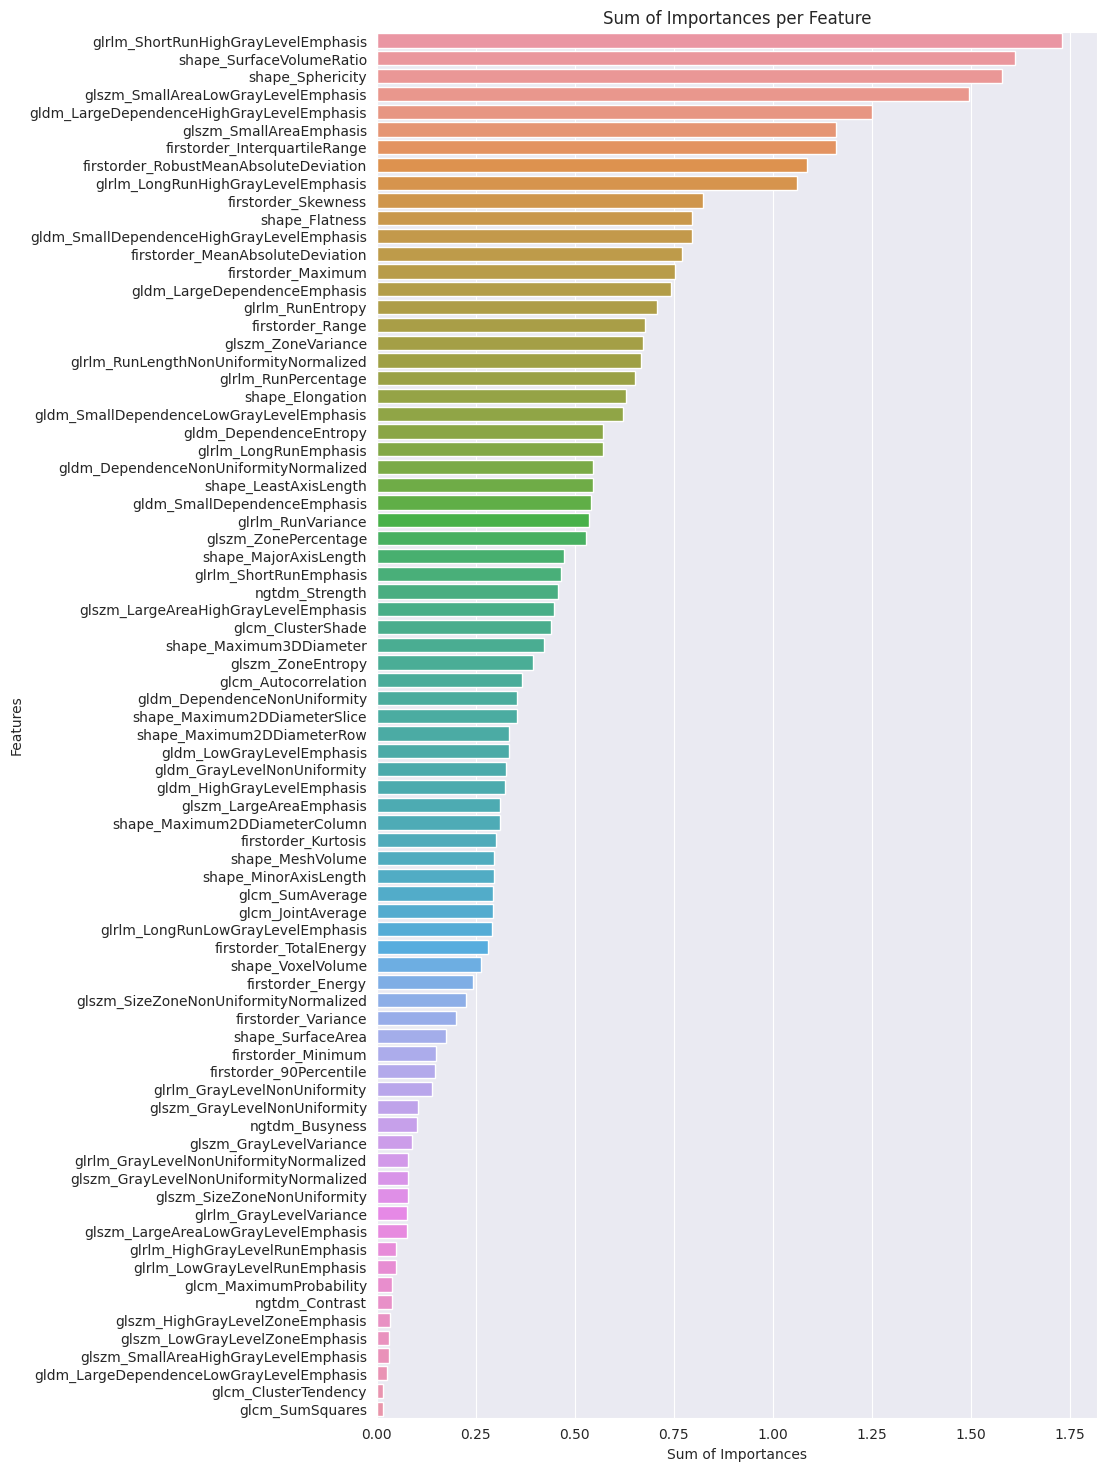

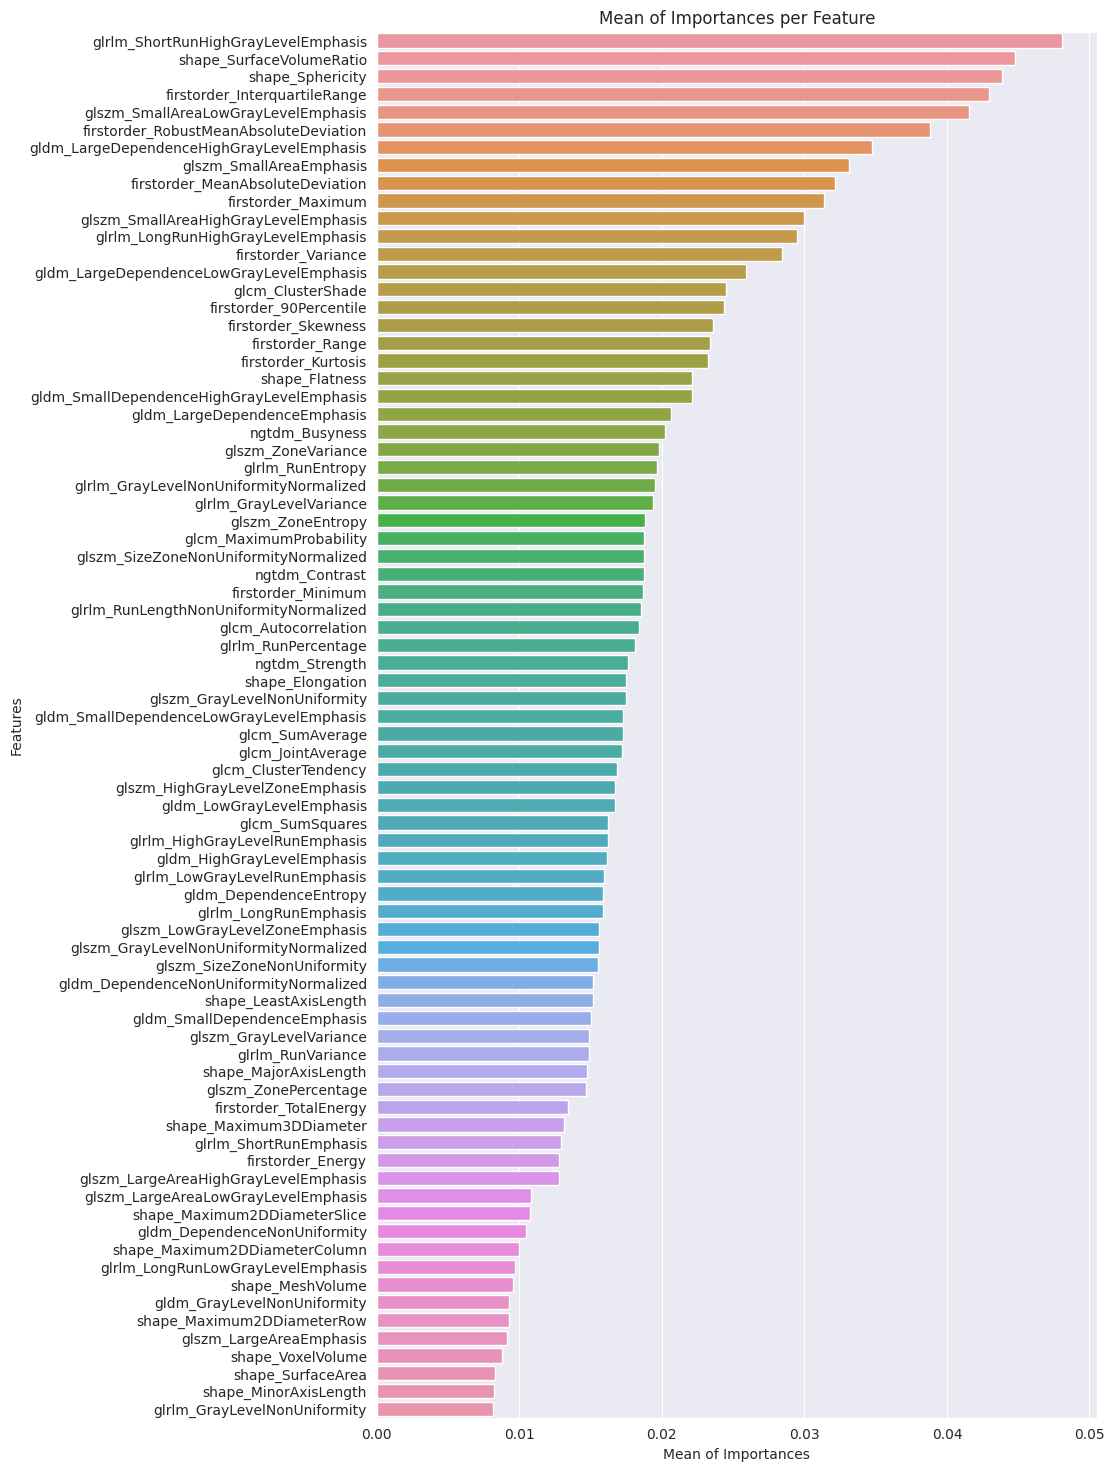

In [61]:

# Calculate the sum of importances per feature
feature_importance_sum = {}
for features, importance in best_features_RF:
    if features in feature_importance_sum:
        feature_importance_sum[features] += importance
    else:
        feature_importance_sum[features] = importance

# Convert the dictionary to lists for plotting
features = list(feature_importance_sum.keys())
importance_sum = list(feature_importance_sum.values())

# Sort the lists in descending order of importance_sum
sorted_indices = sorted(range(len(importance_sum)), key=lambda k: importance_sum[k], reverse=True)
features_sorted = [features[i] for i in sorted_indices]
importance_sum_sorted = [importance_sum[i] for i in sorted_indices]

# Plot the sum of importances per feature
plt.figure(figsize=(12, 18))
sns.barplot(x=importance_sum_sorted, y=features_sorted)
plt.xlabel('Sum of Importances')
plt.ylabel('Features')
plt.title('Sum of Importances per Feature')
plt.subplots_adjust(left=0.3)
plt.show()

feature_importance_mean = {}
feature_importance_sd = {}
feature_importance_ci = {}

for features, importance in best_features_RF:
    if features in feature_importance_mean:
        feature_importance_mean[features].append(importance)
    else:
        feature_importance_mean[features] = [importance]

feature_importance_mean_ = {feature: np.mean(importances) for feature, importances in feature_importance_mean.items()}
feature_importance_sd = {feature: np.std(importances) for feature, importances in feature_importance_mean.items()}

# Convert the dictionary to lists for plotting
features = list(feature_importance_mean_.keys())
importance_mean = list(feature_importance_mean_.values())

# Sort the lists in descending order of importance_mean
sorted_indices = sorted(range(len(importance_mean)), key=lambda k: importance_mean[k], reverse=True)
features_sorted = [features[i] for i in sorted_indices]
importance_mean_sorted = [importance_mean[i] for i in sorted_indices]

# Plot the mean of importances per feature
plt.figure(figsize=(12, 18))
sns.barplot(x=importance_mean_sorted, y=features_sorted)
plt.xlabel('Mean of Importances')
plt.ylabel('Features')
plt.title('Mean of Importances per Feature')

# Adjust the position of the figure
plt.subplots_adjust(left=0.3)

plt.show()

In [62]:
p_value_sum = {}
p_value_mean = {}
p_value_sd = {}

for p_value_dict in p_value:
    for feature, value in p_value_dict.items():
        if feature in p_value_sum:
            p_value_sum[feature] += value
        else:
            p_value_sum[feature] = value

# Calculate the mean and standard deviation of p-values per feature
for feature in p_value_sum:
    p_values_per_feature = [p_value_dict[feature] for p_value_dict in p_value if feature in p_value_dict]
    p_value_mean[feature] = np.mean(p_values_per_feature)
    p_value_sd[feature] = np.std(p_values_per_feature)

print('p_value_mean', p_value_mean)

p_value_mean {'shape_Elongation': 5.3046220023814455e-05, 'shape_Flatness': 2.4351297447469278e-05, 'shape_LeastAxisLength': 0.0023920191556815987, 'shape_MajorAxisLength': 0.0216926367300657, 'shape_Maximum2DDiameterColumn': 0.027950264598745687, 'shape_Maximum2DDiameterRow': 0.011141064359948983, 'shape_Maximum2DDiameterSlice': 0.023937652587581425, 'shape_Maximum3DDiameter': 0.023480644794958812, 'shape_MeshVolume': 0.02035008316066229, 'shape_MinorAxisLength': 0.00763036222749512, 'shape_Sphericity': 1.6989878998720047e-08, 'shape_SurfaceArea': 0.020846420515870746, 'shape_SurfaceVolumeRatio': 1.2641548606147338e-08, 'shape_VoxelVolume': 0.020748003322485577, 'firstorder_Energy': 0.03052501574280409, 'firstorder_InterquartileRange': 0.031913725148202295, 'firstorder_Range': 0.03128986664987418, 'firstorder_Skewness': 0.01297106878895286, 'firstorder_TotalEnergy': 0.036681932592126376, 'glcm_Autocorrelation': 0.05093188566465504, 'glcm_ClusterShade': 0.042130197302268836, 'glcm_Join

In [63]:
print('p_value_sum', p_value_sum)

p_value_sum {'shape_Elongation': 0.00190966392085732, 'shape_Flatness': 0.0008766467081088941, 'shape_LeastAxisLength': 0.08611268960453754, 'shape_MajorAxisLength': 0.6941643753621025, 'shape_Maximum2DDiameterColumn': 0.8664582025611163, 'shape_Maximum2DDiameterRow': 0.4010783169581633, 'shape_Maximum2DDiameterSlice': 0.789942535390187, 'shape_Maximum3DDiameter': 0.7513806334386822, 'shape_MeshVolume': 0.630852577980531, 'shape_MinorAxisLength': 0.27469304018982427, 'shape_Sphericity': 6.116356439539216e-07, 'shape_SurfaceArea': 0.4377748308332856, 'shape_SurfaceVolumeRatio': 4.5509574982130425e-07, 'shape_VoxelVolume': 0.6224400996745674, 'firstorder_Energy': 0.5799752991132778, 'firstorder_InterquartileRange': 0.8616705790014619, 'firstorder_Range': 0.9074061328463513, 'firstorder_Skewness': 0.45398740761335005, 'firstorder_TotalEnergy': 0.7703205844346541, 'glcm_Autocorrelation': 1.0186377132931006, 'glcm_ClusterShade': 0.7583435514408391, 'glcm_JointAverage': 0.9039302376763164, '

In [64]:
print('p_value_sd', p_value_sd)

p_value_sd {'shape_Elongation': 0.000108500659256053, 'shape_Flatness': 5.777083728394784e-05, 'shape_LeastAxisLength': 0.0038175948236600287, 'shape_MajorAxisLength': 0.02650270886533251, 'shape_Maximum2DDiameterColumn': 0.029497463613658594, 'shape_Maximum2DDiameterRow': 0.03360546597970826, 'shape_Maximum2DDiameterSlice': 0.028066866899704137, 'shape_Maximum3DDiameter': 0.02489483313067547, 'shape_MeshVolume': 0.02183563629526615, 'shape_MinorAxisLength': 0.023370721624586466, 'shape_Sphericity': 4.711554714493575e-08, 'shape_SurfaceArea': 0.017274299276059845, 'shape_SurfaceVolumeRatio': 2.8073867336962688e-08, 'shape_VoxelVolume': 0.02265848110149741, 'firstorder_Energy': 0.02764446366678154, 'firstorder_InterquartileRange': 0.025994274580185422, 'firstorder_Range': 0.03538417530951092, 'firstorder_Skewness': 0.010363779370465674, 'firstorder_TotalEnergy': 0.036636378440727584, 'glcm_Autocorrelation': 0.028439969937714204, 'glcm_ClusterShade': 0.02458388317285188, 'glcm_JointAvera

## f 80

In [65]:
# Store the scores and metrics
scores_rf = {'acc': [], 'SD_acc': [], 'CI_acc': [], 'auc_tot': [], 'SD_auc_tot': [], 'CI_auc_tot': [], 'auc_class': [], 'SD_auc_class': [], 'CI_auc_class': [], 'Sen_mean': [], 'Sen_CI': [], 'Sen_SD': [], 'Spe_mean': [], 'Spe_CI': [], 'Spe_sd': []}
scores_svc = {'acc': [], 'SD_acc': [], 'CI_acc': [], 'auc_tot': [], 'SD_auc_tot': [], 'CI_auc_tot': [], 'auc_class': [], 'SD_auc_class': [], 'CI_auc_class': [], 'Sen_mean': [], 'Sen_CI':[], 'Sen_SD': [], 'Spe_mean': [], 'Spe_CI': [], 'Spe_sd': []}
best_features_RF = []
for name, pipeline in pipelines.items():
    # Initialize lists to store scores for each fold
    fold_acc = []
    fold_auc_tot = []
    fold_auc_class = []
    sensi = []
    speci = []
    features = []
    p_value = []
    feat = []
    value = []
    for train_index, test_index in cv_outer.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        scaler = StandardScaler()
        X_train_normed = scaler.fit_transform(X_train)
        X_test_normed = scaler.transform(X_test)

        X_train_scal = pd.DataFrame(X_train_normed, columns=X_train.columns, index=X_train.index)
        X_test_scal = pd.DataFrame(X_test_normed, columns=X_test.columns, index=X_test.index)

        #select the best 15 features
        selector = SelectKBest(f_classif, k=80) #20
        fit = selector.fit(X_train_scal, y_train)
        X_train_new = selector.fit_transform(X_train_scal, y_train)
        X_test_new = selector.transform(X_test_scal)
        selected_features_mask = selector.get_support()
        selected_feature_indices = [i for i, selected in enumerate(selected_features_mask)if selected]
        selected_feature_names = X.columns[selected_feature_indices]
        f_scores, p_values = f_classif(X_train_new, y_train)
        feature_p_values = dict(zip(selected_feature_names, p_values))
        p_value.append(feature_p_values)

        cv_inner = RepeatedStratifiedKFold(n_splits=4, n_repeats=4, random_state=seed)
        grid_search = GridSearchCV(pipeline, param_grids[name], cv=cv_inner, scoring='roc_auc_ovr', error_score="raise")
        grid_search.fit(X_train_new, y_train)
        clf = grid_search.best_estimator_
        print(clf)
        clf.fit(X_train_new, y_train)
        y_pred = clf.predict(X_test_new)
        accuracy = accuracy_score(y_test, y_pred)
        num_classes = len(np.unique(y_test))
        cm = confusion_matrix(y_test, y_pred)
        specificity = calculate_specificity(cm)
        sensitivity = calculate_sensitivity(cm)
        # Print the results
        accuracy = accuracy_score(y_test, y_pred)
        fold_acc.append(accuracy)

        # Calculate AUC score
        auc_tot = multiclass_roc_auc_score(y_test, y_pred)
        fold_auc_tot.append(auc_tot)

        auc_class = class_vs_rest_roc_auc_score(y_test, y_pred)
        fold_auc_class.append(auc_class)

        speci.append(specificity)
        sensi.append(sensitivity)

        print('Auc Score', multiclass_roc_auc_score(y_test, y_pred))
        print('Auc Score OvR', class_vs_rest_roc_auc_score(y_test, y_pred))

        if name == 'rf':
            params_rf = grid_search.best_estimator_
            feature_importance = clf.named_steps['clf'].feature_importances_
            for featureses, importance in zip(selected_feature_names, feature_importance):
                best_features_RF.append((featureses, importance))
        else:
            continue
    # Calculate average scores across folds
    if name == 'rf':
        #acc
        avg_acc = np.mean(fold_acc)
        scores_rf['acc'].append(avg_acc)
        scores_rf['acc'] = scores_rf['acc'][-1]
        ci = stats.t.interval(confidence, len(fold_acc) - 1, loc=np.mean(fold_acc), scale=stats.sem(fold_acc))
        scores_rf['CI_acc'].append(ci)
        scores_rf['SD_acc'].append(np.std(fold_acc))

        #auc_tot
        avg_auc_tot = np.mean(fold_auc_tot)
        scores_rf['auc_tot'].append(avg_auc_tot)
        scores_rf['auc_tot'] = scores_rf['auc_tot'][-1]
        ci = stats.t.interval(confidence, len(fold_auc_tot) - 1, loc=np.mean(fold_auc_tot), scale=stats.sem(fold_auc_tot))
        scores_rf['CI_auc_tot'].append(ci)
        scores_rf['SD_auc_tot'].append(np.std(fold_acc))

        #auc_class
        list_0 = list(d[0] for d in fold_auc_class)
        list_1 = list(d[1] for d in fold_auc_class)
        list_2 = list(d[2] for d in fold_auc_class)

        avg_auc_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_rf['auc_class'].append(avg_auc_class)

        sd_auc_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_rf['SD_auc_class'].append(sd_auc_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_auc_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_rf['CI_auc_class'].append(CI_auc_class)

        #sensitivity
        list_0 = list(d[0] for d in sensi)
        list_1 = list(d[1] for d in sensi)
        list_2 = list(d[2] for d in sensi)

        avg_sensi_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_rf['Sen_mean'].append(avg_sensi_class)

        sd_sensi_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_rf['Sen_SD'].append(sd_sensi_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_sen_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_rf['Sen_CI'].append(CI_sen_class)

        #specificity
        list_0 = list(d[0] for d in speci)
        list_1 = list(d[1] for d in speci)
        list_2 = list(d[2] for d in speci)

        avg_speci_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_rf['Spe_mean'].append(avg_speci_class)
        sd_speci_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_rf['Spe_sd'].append(sd_speci_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_spe_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_rf['Spe_CI'].append(CI_spe_class)

    elif name == 'svc':
        # acc
        avg_acc = np.mean(fold_acc)
        scores_svc['acc'].append(avg_acc)
        scores_svc['acc'] = scores_svc['acc'][-1]
        ci = stats.t.interval(confidence, len(fold_acc) - 1, loc=np.mean(fold_acc), scale=stats.sem(fold_acc))
        scores_svc['CI_acc'].append(ci)
        scores_svc['SD_acc'].append(np.std(fold_acc))

        # auc_tot
        avg_auc_tot = np.mean(fold_auc_tot)
        scores_svc['auc_tot'].append(avg_auc_tot)
        scores_svc['auc_tot'] = scores_svc['auc_tot'][-1]
        ci = stats.t.interval(confidence, len(fold_auc_tot) - 1, loc=np.mean(fold_auc_tot), scale=stats.sem(fold_auc_tot))
        scores_svc['CI_auc_tot'].append(ci)
        scores_svc['SD_auc_tot'].append(np.std(fold_acc))

        # auc_class
        list_0 = list(d[0] for d in fold_auc_class)
        list_1 = list(d[1] for d in fold_auc_class)
        list_2 = list(d[2] for d in fold_auc_class)

        avg_auc_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_svc['auc_class'].append(avg_auc_class)

        sd_auc_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_svc['SD_auc_class'].append(sd_auc_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_auc_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_svc['CI_auc_class'].append(CI_auc_class)

        # sensitivity
        list_0 = list(d[0] for d in sensi)
        list_1 = list(d[1] for d in sensi)
        list_2 = list(d[2] for d in sensi)

        avg_sensi_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_svc['Sen_mean'].append(avg_sensi_class)

        sd_sensi_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_svc['Sen_SD'].append(sd_sensi_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_sen_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_svc['Sen_CI'].append(CI_sen_class)

        # specificity
        list_0 = list(d[0] for d in speci)
        list_1 = list(d[1] for d in speci)
        list_2 = list(d[2] for d in speci)

        avg_speci_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_svc['Spe_mean'].append(avg_speci_class)

        sd_speci_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_svc['Spe_sd'].append(sd_speci_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_spe_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_svc['Spe_CI'].append(CI_spe_class)

Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.6673834120267829
Auc Score OvR {0: 0.7283549783549784, 1: 0.5955165692007798, 2: 0.6782786885245902}
Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.6088602169994175
Auc Score OvR {0: 0.524891774891775, 1: 0.5243664717348928, 2: 0.7773224043715847}
Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.6598955028200312
Auc Score OvR {0: 0.7510822510822511, 1: 0.629245283018868, 2: 0.5993589743589743

In [66]:

for name, score in scores_svc.items():
    print('svc', f'{name}: {score}')

for name, score in scores_rf.items():
    print('rf', f'{name}: {score}')

svc acc: 0.3645357686453577
svc SD_acc: [0.052290360384480615]
svc CI_acc: [(0.3465922859541923, 0.3824792513365231)]
svc auc_tot: 0.6359997210453732
svc SD_auc_tot: [0.052290360384480615]
svc CI_auc_tot: [(0.6189876263538441, 0.6530118157369023)]
svc auc_class: [{0: 0.665509932300977, 1: 0.5368995222741224, 2: 0.70558970856102}]
svc SD_auc_class: [{0: 0.10253198663465188, 1: 0.05500087878255479, 2: 0.06077133528778421}]
svc CI_auc_class: [{0: (0.630325991820511, 0.700693872781443), 1: (0.5180259228348161, 0.5557731217134287), 2: (0.6847359719480476, 0.7264434451739924)}]
svc Sen_mean: [{0: 66.6005291005291, 1: 23.19861790511686, 2: 76.15740740740742}]
svc Sen_CI: [{0: (60.07998312957935, 73.12107507147886), 1: (20.974160758930797, 25.42307505130292), 2: (72.48620271888836, 79.82861209592647)}]
svc Sen_SD: [{0: 19.001979971948803, 1: 6.482446459023928, 2: 10.698514859792137}]
svc Spe_mean: [{0: 66.50145735966632, 1: 84.18128654970761, 2: 64.9605343047966}]
svc Spe_CI: [{0: (64.49800972

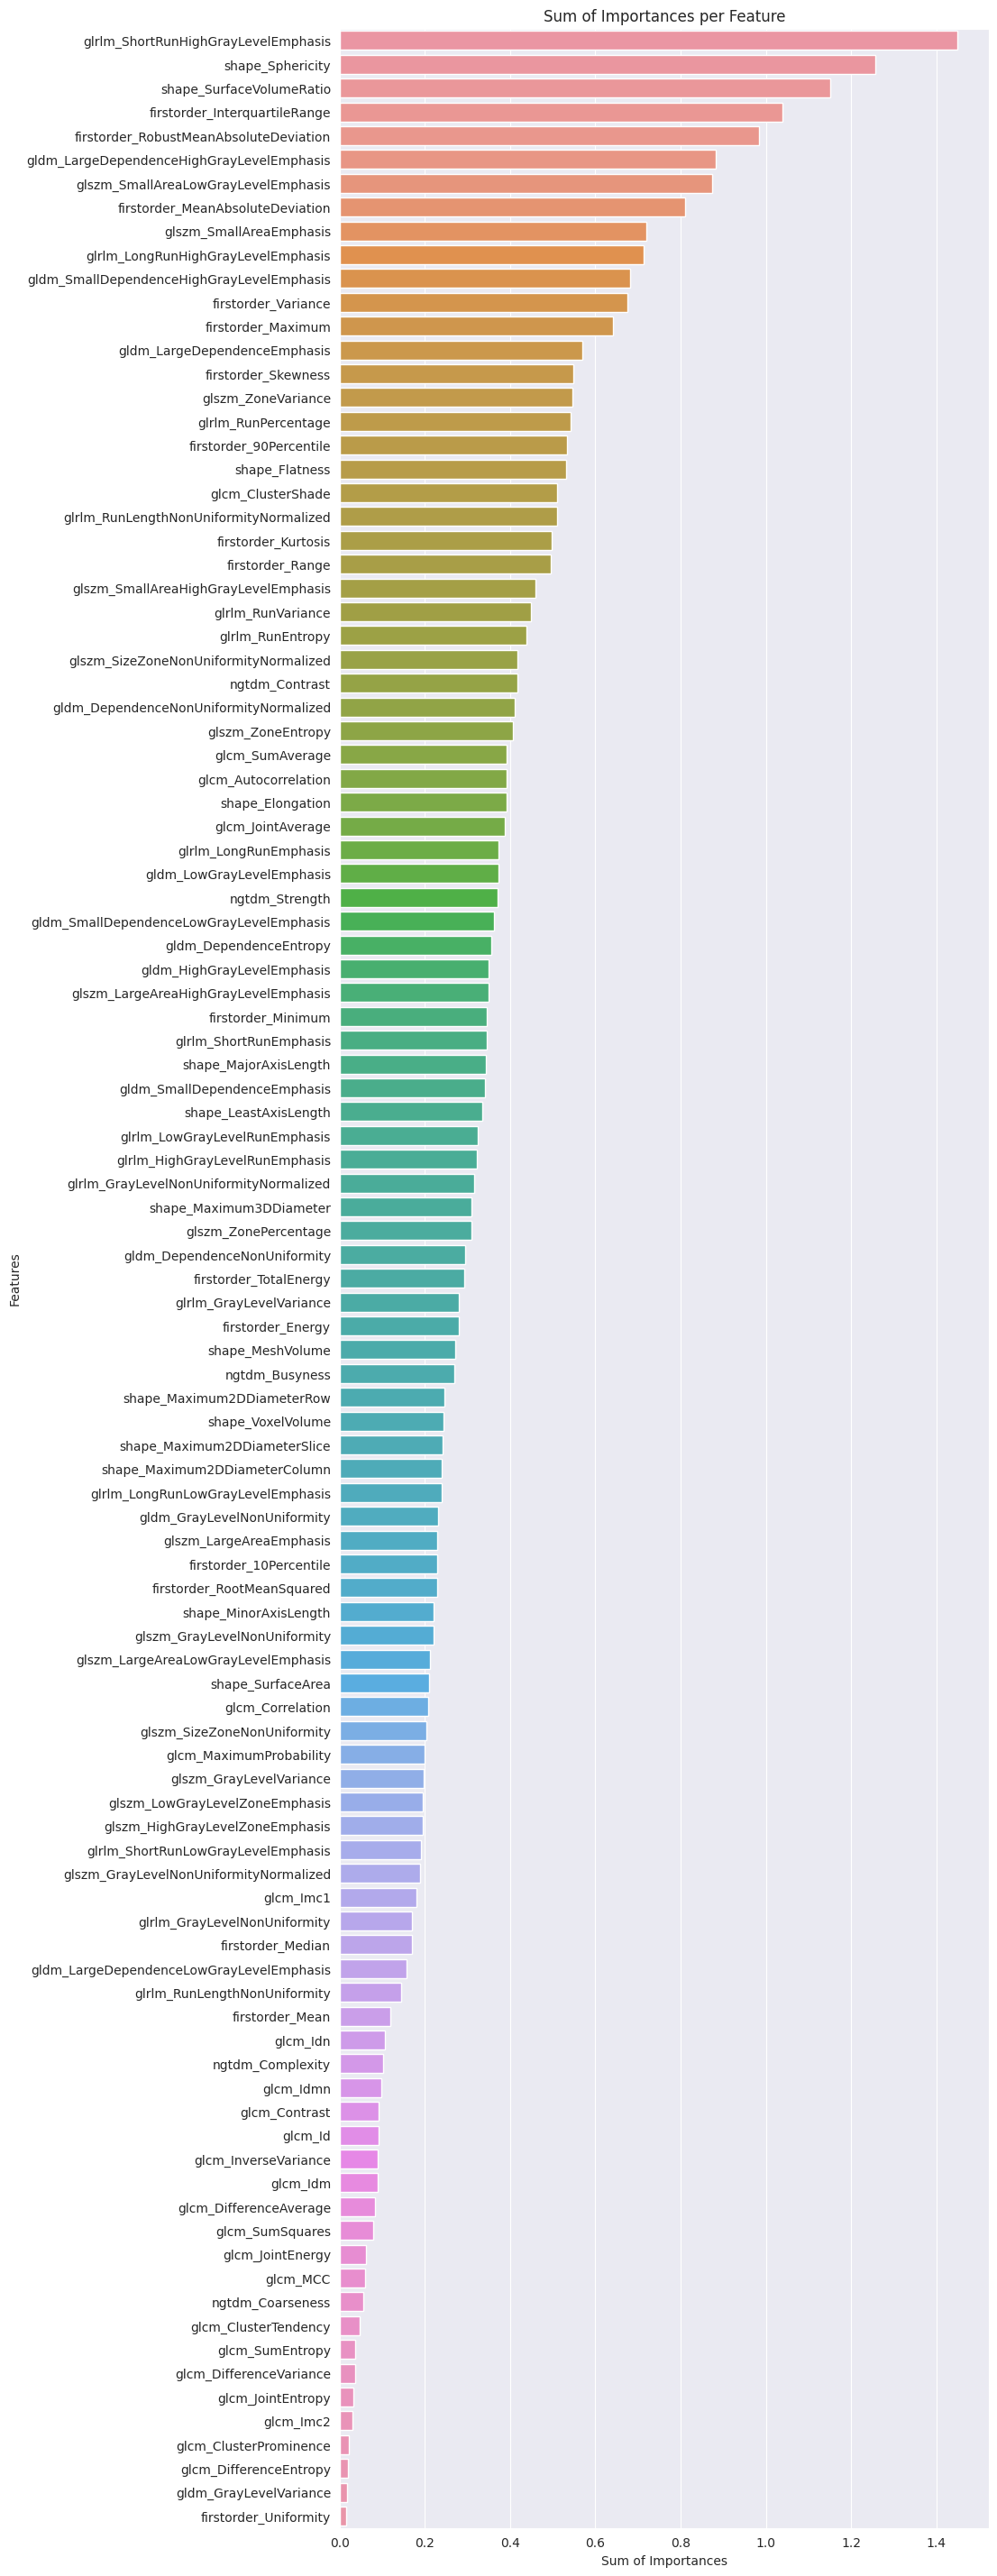

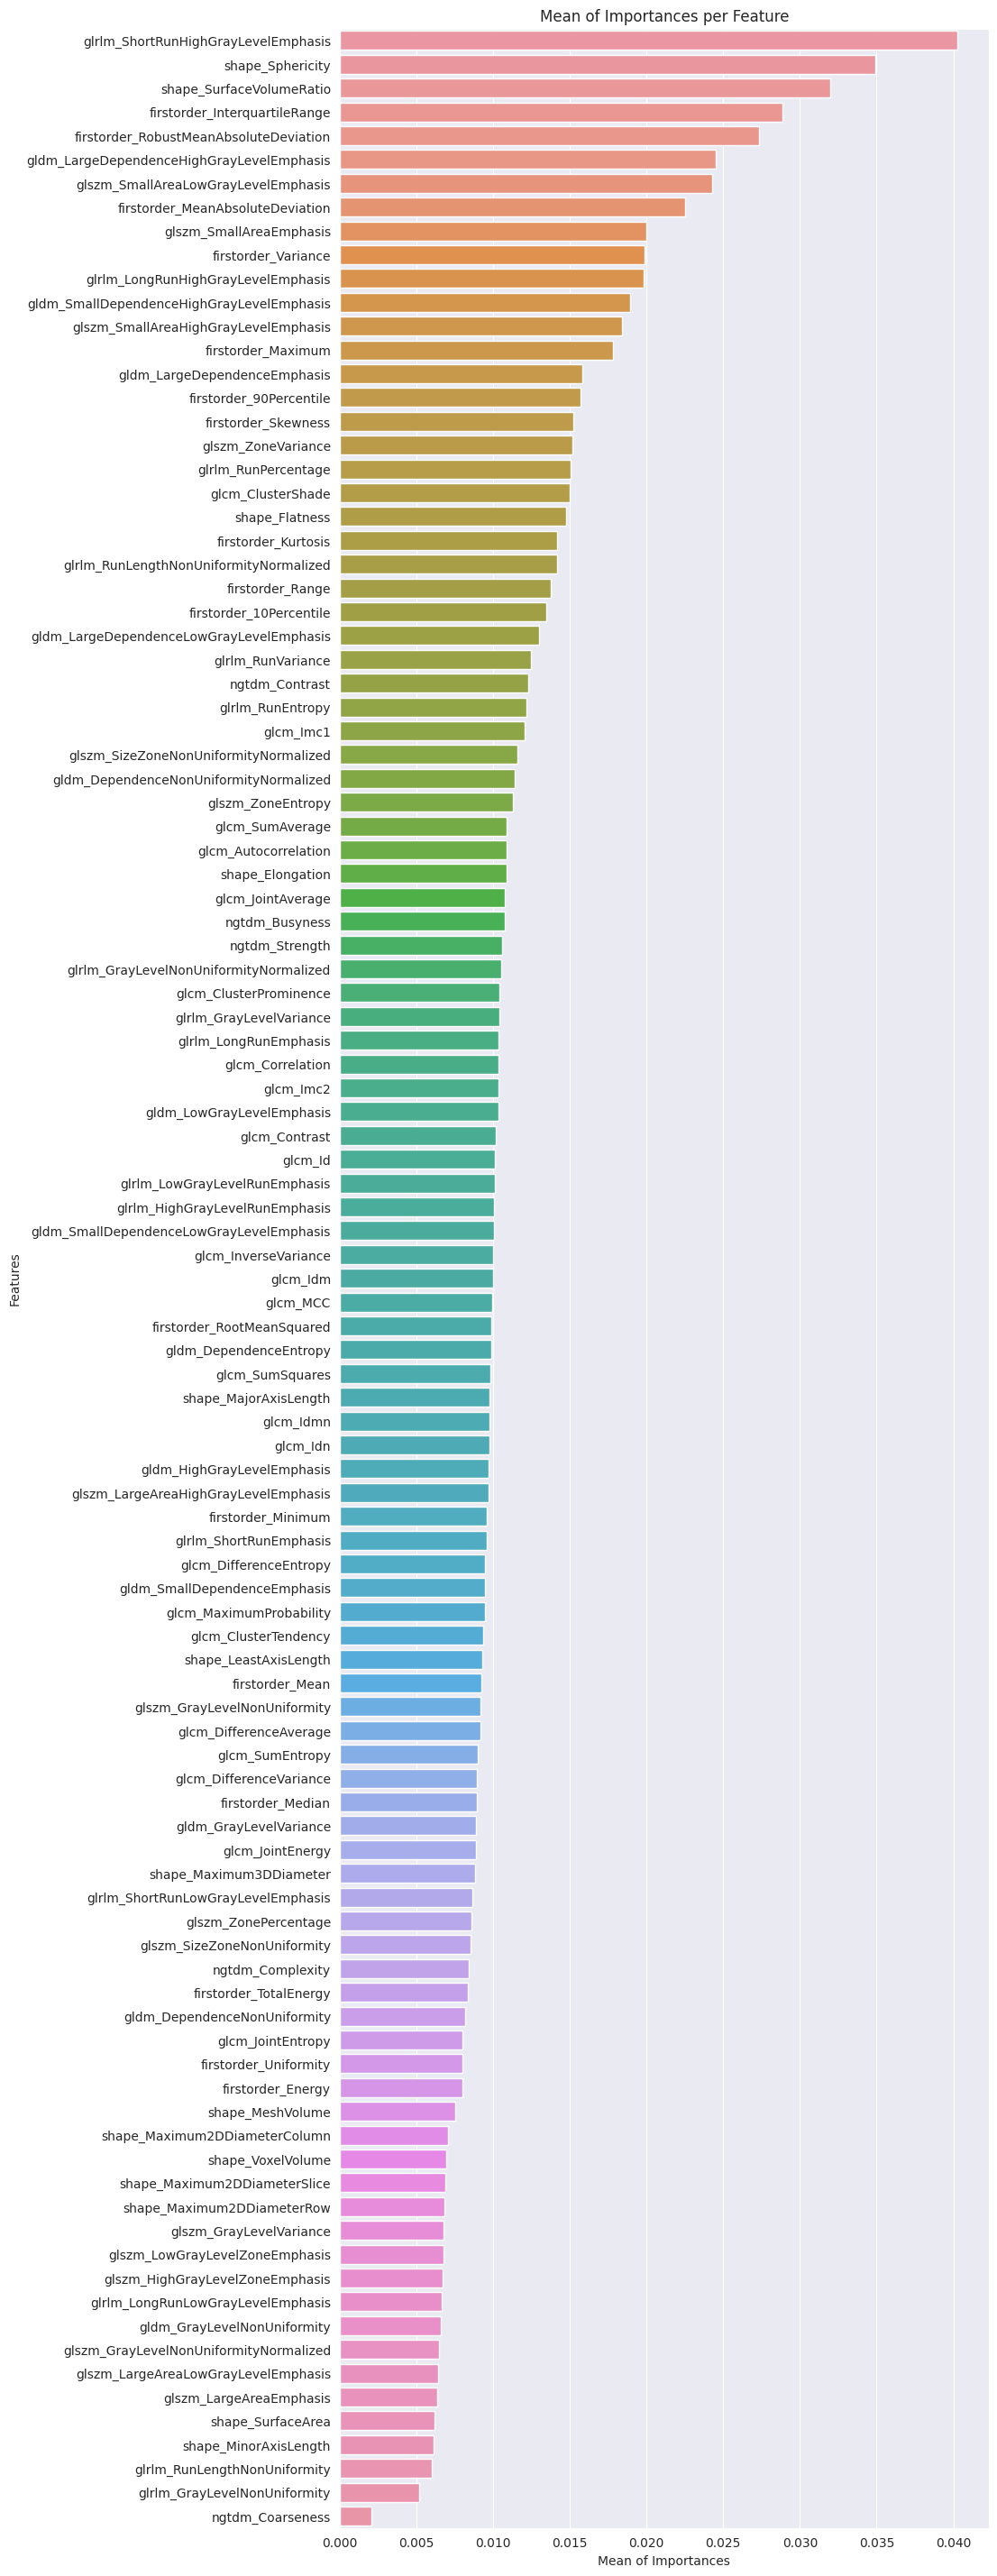

In [67]:

# Calculate the sum of importances per feature
feature_importance_sum = {}
for features, importance in best_features_RF:
    if features in feature_importance_sum:
        feature_importance_sum[features] += importance
    else:
        feature_importance_sum[features] = importance

# Convert the dictionary to lists for plotting
features = list(feature_importance_sum.keys())
importance_sum = list(feature_importance_sum.values())

# Sort the lists in descending order of importance_sum
sorted_indices = sorted(range(len(importance_sum)), key=lambda k: importance_sum[k], reverse=True)
features_sorted = [features[i] for i in sorted_indices]
importance_sum_sorted = [importance_sum[i] for i in sorted_indices]

# Plot the sum of importances per feature
plt.figure(figsize=(12, 36))
sns.barplot(x=importance_sum_sorted, y=features_sorted)
plt.xlabel('Sum of Importances')
plt.ylabel('Features')
plt.title('Sum of Importances per Feature')
plt.subplots_adjust(left=0.3)
plt.show()

feature_importance_mean = {}
feature_importance_sd = {}
feature_importance_ci = {}

for features, importance in best_features_RF:
    if features in feature_importance_mean:
        feature_importance_mean[features].append(importance)
    else:
        feature_importance_mean[features] = [importance]

feature_importance_mean_ = {feature: np.mean(importances) for feature, importances in feature_importance_mean.items()}
feature_importance_sd = {feature: np.std(importances) for feature, importances in feature_importance_mean.items()}

# Convert the dictionary to lists for plotting
features = list(feature_importance_mean_.keys())
importance_mean = list(feature_importance_mean_.values())

# Sort the lists in descending order of importance_mean
sorted_indices = sorted(range(len(importance_mean)), key=lambda k: importance_mean[k], reverse=True)
features_sorted = [features[i] for i in sorted_indices]
importance_mean_sorted = [importance_mean[i] for i in sorted_indices]

# Plot the mean of importances per feature
plt.figure(figsize=(12, 36))
sns.barplot(x=importance_mean_sorted, y=features_sorted)
plt.xlabel('Mean of Importances')
plt.ylabel('Features')
plt.title('Mean of Importances per Feature')

# Adjust the position of the figure
plt.subplots_adjust(left=0.3)

plt.show()

In [68]:

p_value_sum = {}
p_value_mean = {}
p_value_sd = {}

for p_value_dict in p_value:
    for feature, value in p_value_dict.items():
        if feature in p_value_sum:
            p_value_sum[feature] += value
        else:
            p_value_sum[feature] = value

# Calculate the mean and standard deviation of p-values per feature
for feature in p_value_sum:
    p_values_per_feature = [p_value_dict[feature] for p_value_dict in p_value if feature in p_value_dict]
    p_value_mean[feature] = np.mean(p_values_per_feature)
    p_value_sd[feature] = np.std(p_values_per_feature)

print('p_value_mean', p_value_mean)

p_value_mean {'shape_Elongation': 5.3046220023814455e-05, 'shape_Flatness': 2.4351297447469278e-05, 'shape_LeastAxisLength': 0.0023920191556815987, 'shape_MajorAxisLength': 0.031403945554579565, 'shape_Maximum2DDiameterColumn': 0.03644696870235301, 'shape_Maximum2DDiameterRow': 0.011141064359948983, 'shape_Maximum2DDiameterSlice': 0.0307020154444337, 'shape_Maximum3DDiameter': 0.03617859738083147, 'shape_MeshVolume': 0.04425838032351976, 'shape_MinorAxisLength': 0.00763036222749512, 'shape_Sphericity': 1.6989878998720047e-08, 'shape_SurfaceArea': 0.06329465441156953, 'shape_SurfaceVolumeRatio': 1.2641548606147338e-08, 'shape_VoxelVolume': 0.03530130749405928, 'firstorder_10Percentile': 0.2764311036580336, 'firstorder_Energy': 0.07784203218384393, 'firstorder_InterquartileRange': 0.05238467222821548, 'firstorder_Kurtosis': 0.10760180977081142, 'firstorder_Maximum': 0.05360222219097033, 'firstorder_MeanAbsoluteDeviation': 0.06687246766222031, 'firstorder_Median': 0.21290360019653423, 'fi

In [ ]:
print('p_value_sum', p_value_sum)

In [ ]:
print('p_value_sd', p_value_sd)

## All features

In [69]:
# Store the scores and metrics
scores_rf = {'acc': [], 'SD_acc': [], 'CI_acc': [], 'auc_tot': [], 'SD_auc_tot': [], 'CI_auc_tot': [], 'auc_class': [], 'SD_auc_class': [], 'CI_auc_class': [], 'Sen_mean': [], 'Sen_CI': [], 'Sen_SD': [], 'Spe_mean': [], 'Spe_CI': [], 'Spe_sd': []}
scores_svc = {'acc': [], 'SD_acc': [], 'CI_acc': [], 'auc_tot': [], 'SD_auc_tot': [], 'CI_auc_tot': [], 'auc_class': [], 'SD_auc_class': [], 'CI_auc_class': [], 'Sen_mean': [], 'Sen_CI':[], 'Sen_SD': [], 'Spe_mean': [], 'Spe_CI': [], 'Spe_sd': []}
best_features_RF = []
for name, pipeline in pipelines.items():
    # Initialize lists to store scores for each fold
    fold_acc = []
    fold_auc_tot = []
    fold_auc_class = []
    sensi = []
    speci = []
    features = []
    p_value = []
    feat = []
    value = []
    for train_index, test_index in cv_outer.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        scaler = StandardScaler()
        X_train_normed = scaler.fit_transform(X_train)
        X_test_normed = scaler.transform(X_test)

        X_train_scal = pd.DataFrame(X_train_normed, columns=X_train.columns, index=X_train.index)
        X_test_scal = pd.DataFrame(X_test_normed, columns=X_test.columns, index=X_test.index)

        #select the best 15 features
        selector = SelectKBest(f_classif, k=107) #20
        fit = selector.fit(X_train_scal, y_train)
        X_train_new = selector.fit_transform(X_train_scal, y_train)
        X_test_new = selector.transform(X_test_scal)
        selected_features_mask = selector.get_support()
        selected_feature_indices = [i for i, selected in enumerate(selected_features_mask)if selected]
        selected_feature_names = X.columns[selected_feature_indices]
        f_scores, p_values = f_classif(X_train_new, y_train)
        feature_p_values = dict(zip(selected_feature_names, p_values))
        p_value.append(feature_p_values)

        cv_inner = RepeatedStratifiedKFold(n_splits=4, n_repeats=4, random_state=seed)
        grid_search = GridSearchCV(pipeline, param_grids[name], cv=cv_inner, scoring='roc_auc_ovr', error_score="raise")
        grid_search.fit(X_train_new, y_train)
        clf = grid_search.best_estimator_
        print(clf)
        clf.fit(X_train_new, y_train)
        y_pred = clf.predict(X_test_new)
        accuracy = accuracy_score(y_test, y_pred)
        num_classes = len(np.unique(y_test))
        cm = confusion_matrix(y_test, y_pred)
        specificity = calculate_specificity(cm)
        sensitivity = calculate_sensitivity(cm)
        # Print the results
        accuracy = accuracy_score(y_test, y_pred)
        fold_acc.append(accuracy)

        # Calculate AUC score
        auc_tot = multiclass_roc_auc_score(y_test, y_pred)
        fold_auc_tot.append(auc_tot)

        auc_class = class_vs_rest_roc_auc_score(y_test, y_pred)
        fold_auc_class.append(auc_class)

        speci.append(specificity)
        sensi.append(sensitivity)

        print('Auc Score', multiclass_roc_auc_score(y_test, y_pred))
        print('Auc Score OvR', class_vs_rest_roc_auc_score(y_test, y_pred))

        if name == 'rf':
            params_rf = grid_search.best_estimator_
            feature_importance = clf.named_steps['clf'].feature_importances_
            for featureses, importance in zip(selected_feature_names, feature_importance):
                best_features_RF.append((featureses, importance))
        else:
            continue
    # Calculate average scores across folds
    if name == 'rf':
        #acc
        avg_acc = np.mean(fold_acc)
        scores_rf['acc'].append(avg_acc)
        scores_rf['acc'] = scores_rf['acc'][-1]
        ci = stats.t.interval(confidence, len(fold_acc) - 1, loc=np.mean(fold_acc), scale=stats.sem(fold_acc))
        scores_rf['CI_acc'].append(ci)
        scores_rf['SD_acc'].append(np.std(fold_acc))

        #auc_tot
        avg_auc_tot = np.mean(fold_auc_tot)
        scores_rf['auc_tot'].append(avg_auc_tot)
        scores_rf['auc_tot'] = scores_rf['auc_tot'][-1]
        ci = stats.t.interval(confidence, len(fold_auc_tot) - 1, loc=np.mean(fold_auc_tot), scale=stats.sem(fold_auc_tot))
        scores_rf['CI_auc_tot'].append(ci)
        scores_rf['SD_auc_tot'].append(np.std(fold_acc))

        #auc_class
        list_0 = list(d[0] for d in fold_auc_class)
        list_1 = list(d[1] for d in fold_auc_class)
        list_2 = list(d[2] for d in fold_auc_class)

        avg_auc_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_rf['auc_class'].append(avg_auc_class)

        sd_auc_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_rf['SD_auc_class'].append(sd_auc_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_auc_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_rf['CI_auc_class'].append(CI_auc_class)

        #sensitivity
        list_0 = list(d[0] for d in sensi)
        list_1 = list(d[1] for d in sensi)
        list_2 = list(d[2] for d in sensi)

        avg_sensi_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_rf['Sen_mean'].append(avg_sensi_class)

        sd_sensi_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_rf['Sen_SD'].append(sd_sensi_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_sen_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_rf['Sen_CI'].append(CI_sen_class)

        #specificity
        list_0 = list(d[0] for d in speci)
        list_1 = list(d[1] for d in speci)
        list_2 = list(d[2] for d in speci)

        avg_speci_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_rf['Spe_mean'].append(avg_speci_class)
        sd_speci_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_rf['Spe_sd'].append(sd_speci_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_spe_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_rf['Spe_CI'].append(CI_spe_class)

    elif name == 'svc':
        # acc
        avg_acc = np.mean(fold_acc)
        scores_svc['acc'].append(avg_acc)
        scores_svc['acc'] = scores_svc['acc'][-1]
        ci = stats.t.interval(confidence, len(fold_acc) - 1, loc=np.mean(fold_acc), scale=stats.sem(fold_acc))
        scores_svc['CI_acc'].append(ci)
        scores_svc['SD_acc'].append(np.std(fold_acc))

        # auc_tot
        avg_auc_tot = np.mean(fold_auc_tot)
        scores_svc['auc_tot'].append(avg_auc_tot)
        scores_svc['auc_tot'] = scores_svc['auc_tot'][-1]
        ci = stats.t.interval(confidence, len(fold_auc_tot) - 1, loc=np.mean(fold_auc_tot), scale=stats.sem(fold_auc_tot))
        scores_svc['CI_auc_tot'].append(ci)
        scores_svc['SD_auc_tot'].append(np.std(fold_acc))

        # auc_class
        list_0 = list(d[0] for d in fold_auc_class)
        list_1 = list(d[1] for d in fold_auc_class)
        list_2 = list(d[2] for d in fold_auc_class)

        avg_auc_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_svc['auc_class'].append(avg_auc_class)

        sd_auc_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_svc['SD_auc_class'].append(sd_auc_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_auc_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_svc['CI_auc_class'].append(CI_auc_class)

        # sensitivity
        list_0 = list(d[0] for d in sensi)
        list_1 = list(d[1] for d in sensi)
        list_2 = list(d[2] for d in sensi)

        avg_sensi_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_svc['Sen_mean'].append(avg_sensi_class)

        sd_sensi_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_svc['Sen_SD'].append(sd_sensi_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_sen_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_svc['Sen_CI'].append(CI_sen_class)

        # specificity
        list_0 = list(d[0] for d in speci)
        list_1 = list(d[1] for d in speci)
        list_2 = list(d[2] for d in speci)

        avg_speci_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_svc['Spe_mean'].append(avg_speci_class)

        sd_speci_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_svc['Spe_sd'].append(sd_speci_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_spe_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_svc['Spe_CI'].append(CI_spe_class)

Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.6619787276603497
Auc Score OvR {0: 0.7132034632034633, 1: 0.5862573099415204, 2: 0.6864754098360656}
Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.6023526692206588
Auc Score OvR {0: 0.5811688311688311, 1: 0.5073099415204678, 2: 0.7185792349726775}
Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6854620746130179
Auc Score OvR {0: 0.777056277056277, 1: 0.6165094339622641, 2: 0.66282051282051

In [70]:

for name, score in scores_svc.items():
    print('svc', f'{name}: {score}')

for name, score in scores_rf.items():
    print('rf', f'{name}: {score}')

svc acc: 0.37823439878234394
svc SD_acc: [0.05327788621974776]
svc CI_acc: [(0.3599520457410431, 0.39651675182364476)]
svc auc_tot: 0.6454971429768025
svc SD_auc_tot: [0.05327788621974776]
svc CI_auc_tot: [(0.6307792300606673, 0.6602150558929377)]
svc auc_class: [{0: 0.6664481524556151, 1: 0.5475959947037405, 2: 0.7224472817710524}]
svc SD_auc_class: [{0: 0.10175800819115649, 1: 0.050112466297441975, 2: 0.06039640606742273}]
svc CI_auc_class: [{0: (0.6315298033518786, 0.7013665015593515), 1: (0.5303998582646687, 0.5647921311428123), 2: (0.7017222024464693, 0.7431723610956356)}]
svc Sen_mean: [{0: 66.99735449735451, 1: 24.606918238993707, 2: 77.86680911680912}]
svc Sen_CI: [{0: (60.665322564314245, 73.32938643039478), 1: (22.20759625869161, 27.006240219295805), 2: (74.38166509315337, 81.35195314046487)}]
svc Sen_SD: [{0: 18.452618003066682, 1: 6.992032326599228, 2: 10.156302437235583}]
svc Spe_mean: [{0: 66.29227599376851, 1: 84.91228070175437, 2: 66.62264723740134}]
svc Spe_CI: [{0: (6

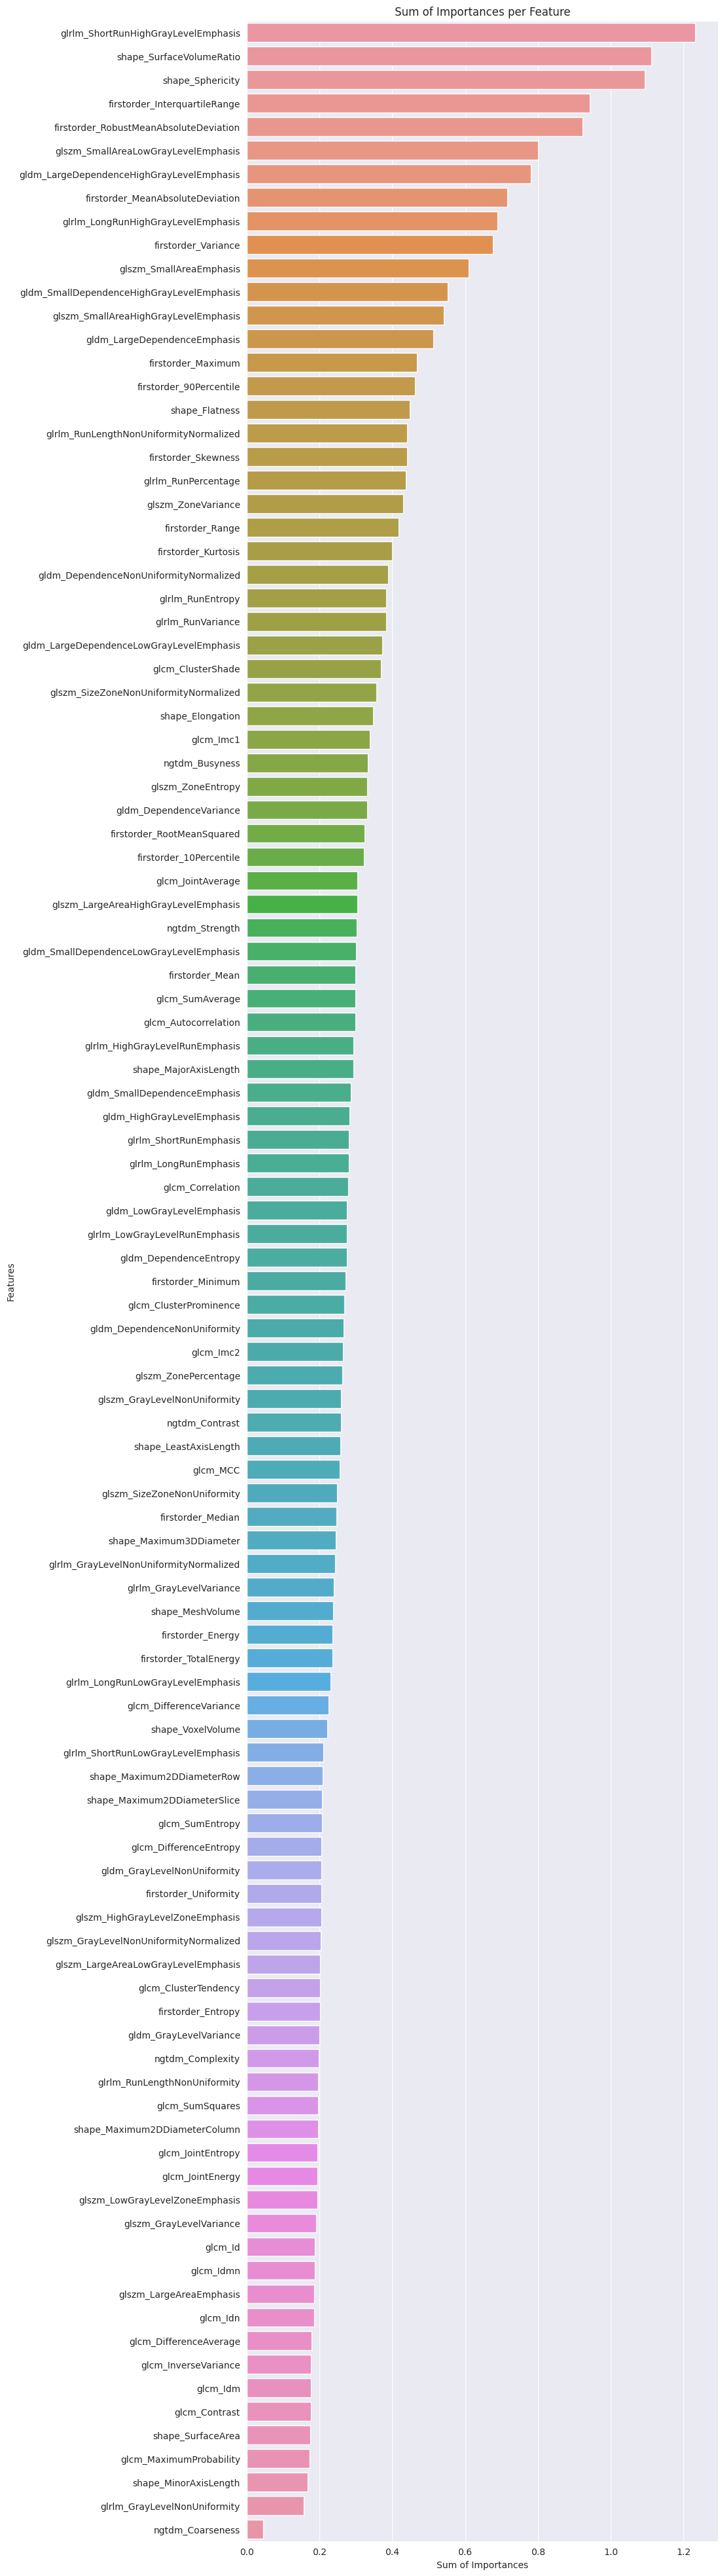

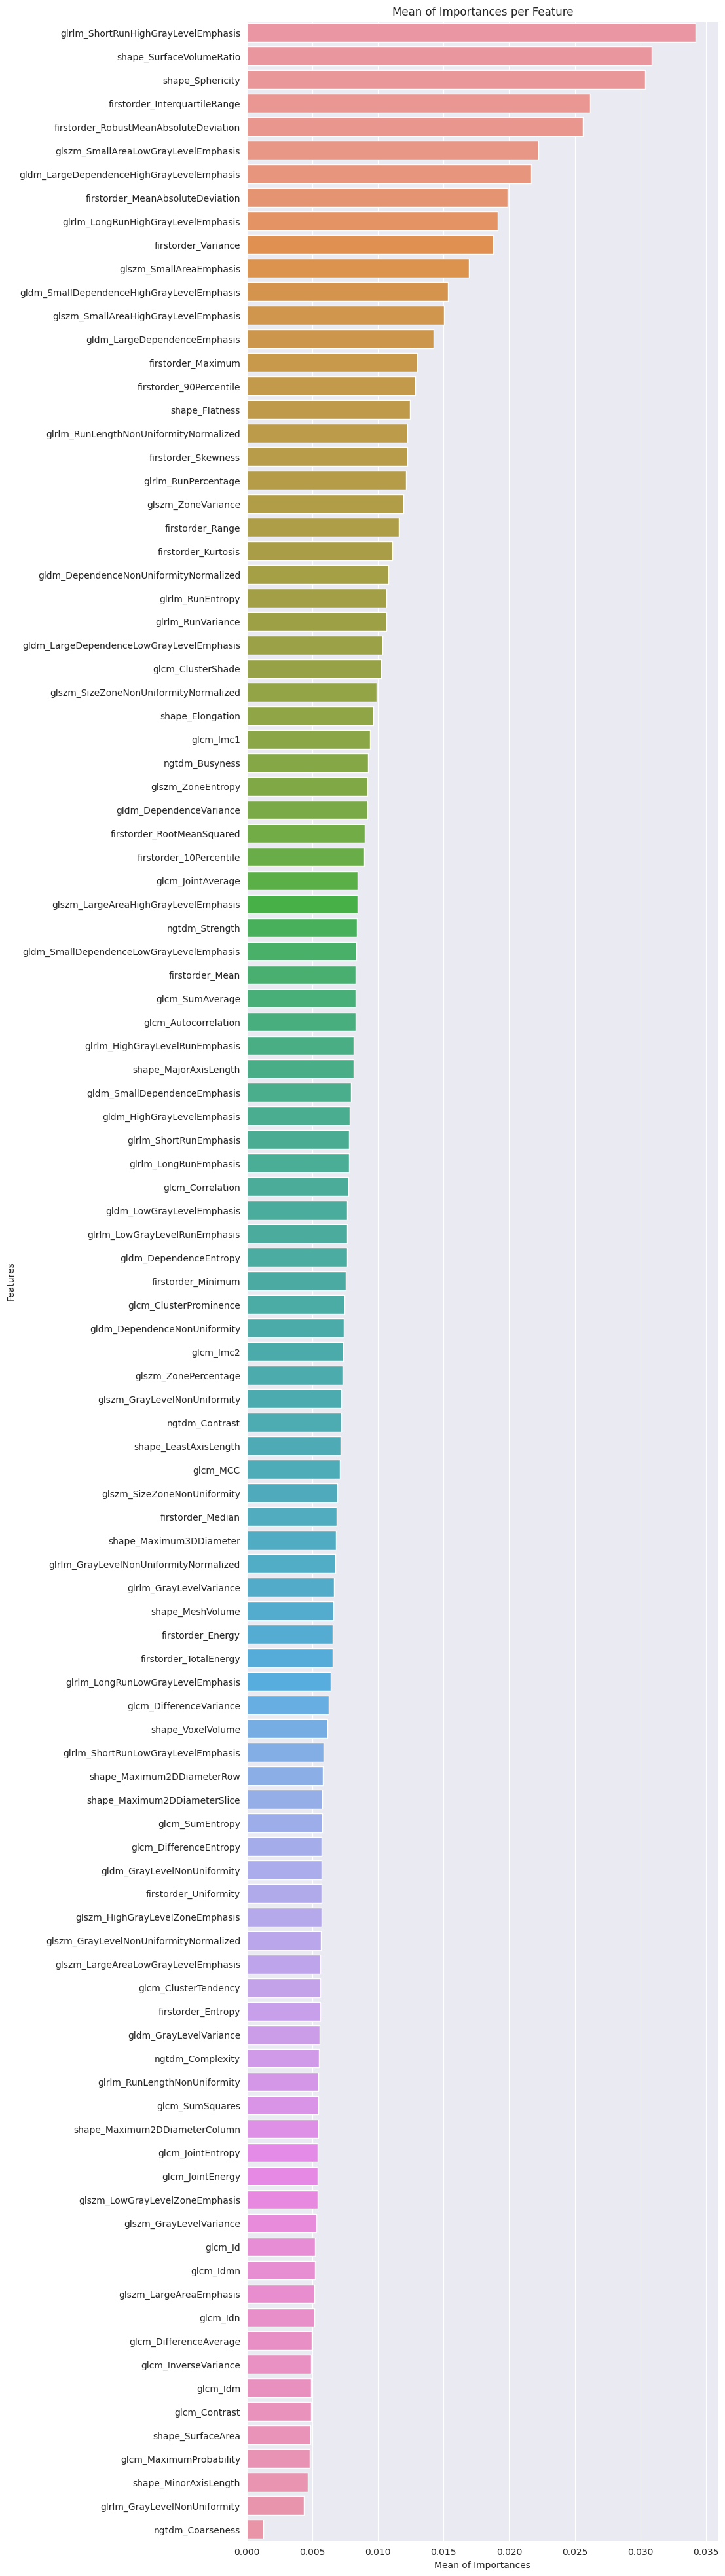

In [76]:

# Calculate the sum of importances per feature
feature_importance_sum = {}
for features, importance in best_features_RF:
    if features in feature_importance_sum:
        feature_importance_sum[features] += importance
    else:
        feature_importance_sum[features] = importance

# Convert the dictionary to lists for plotting
features = list(feature_importance_sum.keys())
importance_sum = list(feature_importance_sum.values())

# Sort the lists in descending order of importance_sum
sorted_indices = sorted(range(len(importance_sum)), key=lambda k: importance_sum[k], reverse=True)
features_sorted = [features[i] for i in sorted_indices]
importance_sum_sorted = [importance_sum[i] for i in sorted_indices]

# Plot the sum of importances per feature
plt.figure(figsize=(12, 50))
sns.barplot(x=importance_sum_sorted, y=features_sorted)
plt.xlabel('Sum of Importances')
plt.ylabel('Features')
plt.title('Sum of Importances per Feature')
plt.subplots_adjust(left=0.3)
plt.show()

feature_importance_mean = {}
feature_importance_sd = {}
feature_importance_ci = {}

for features, importance in best_features_RF:
    if features in feature_importance_mean:
        feature_importance_mean[features].append(importance)
    else:
        feature_importance_mean[features] = [importance]

feature_importance_mean_ = {feature: np.mean(importances) for feature, importances in feature_importance_mean.items()}
feature_importance_sd = {feature: np.std(importances) for feature, importances in feature_importance_mean.items()}

# Convert the dictionary to lists for plotting
features = list(feature_importance_mean_.keys())
importance_mean = list(feature_importance_mean_.values())

# Sort the lists in descending order of importance_mean
sorted_indices = sorted(range(len(importance_mean)), key=lambda k: importance_mean[k], reverse=True)
features_sorted = [features[i] for i in sorted_indices]
importance_mean_sorted = [importance_mean[i] for i in sorted_indices]

# Plot the mean of importances per feature
plt.figure(figsize=(12, 50))
sns.barplot(x=importance_mean_sorted, y=features_sorted)
plt.xlabel('Mean of Importances')
plt.ylabel('Features')
plt.title('Mean of Importances per Feature')

# Adjust the position of the figure
plt.subplots_adjust(left=0.3)

plt.show()

In [72]:

p_value_sum = {}
p_value_mean = {}
p_value_sd = {}

for p_value_dict in p_value:
    for feature, value in p_value_dict.items():
        if feature in p_value_sum:
            p_value_sum[feature] += value
        else:
            p_value_sum[feature] = value

# Calculate the mean and standard deviation of p-values per feature
for feature in p_value_sum:
    p_values_per_feature = [p_value_dict[feature] for p_value_dict in p_value if feature in p_value_dict]
    p_value_mean[feature] = np.mean(p_values_per_feature)
    p_value_sd[feature] = np.std(p_values_per_feature)

print('p_value_mean', p_value_mean)

p_value_mean {'shape_Elongation': 5.3046220023814455e-05, 'shape_Flatness': 2.4351297447469278e-05, 'shape_LeastAxisLength': 0.0023920191556815987, 'shape_MajorAxisLength': 0.04433346519046712, 'shape_Maximum2DDiameterColumn': 0.0611966621534838, 'shape_Maximum2DDiameterRow': 0.011141064359948983, 'shape_Maximum2DDiameterSlice': 0.04319228340239842, 'shape_Maximum3DDiameter': 0.050386093502082535, 'shape_MeshVolume': 0.04425838032351976, 'shape_MinorAxisLength': 0.00763036222749512, 'shape_Sphericity': 1.6989878998720047e-08, 'shape_SurfaceArea': 0.0930150979844497, 'shape_SurfaceVolumeRatio': 1.2641548606147338e-08, 'shape_VoxelVolume': 0.045501636148301675, 'firstorder_10Percentile': 0.38836642840003355, 'firstorder_90Percentile': 0.17217986549268127, 'firstorder_Energy': 0.09132019498098254, 'firstorder_Entropy': 0.7038201284182075, 'firstorder_InterquartileRange': 0.05238467222821548, 'firstorder_Kurtosis': 0.11751784225118686, 'firstorder_Maximum': 0.05360222219097033, 'firstorder

In [73]:
print('p_value_sum', p_value_sum)

p_value_sum {'shape_Elongation': 0.00190966392085732, 'shape_Flatness': 0.0008766467081088941, 'shape_LeastAxisLength': 0.08611268960453754, 'shape_MajorAxisLength': 1.5960047468568161, 'shape_Maximum2DDiameterColumn': 2.203079837525417, 'shape_Maximum2DDiameterRow': 0.4010783169581633, 'shape_Maximum2DDiameterSlice': 1.554922202486343, 'shape_Maximum3DDiameter': 1.8138993660749716, 'shape_MeshVolume': 1.5933016916467113, 'shape_MinorAxisLength': 0.27469304018982427, 'shape_Sphericity': 6.116356439539216e-07, 'shape_SurfaceArea': 3.348543527440189, 'shape_SurfaceVolumeRatio': 4.5509574982130425e-07, 'shape_VoxelVolume': 1.6380589013388605, 'firstorder_10Percentile': 13.981191422401206, 'firstorder_90Percentile': 6.198475157736526, 'firstorder_Energy': 3.2875270193153714, 'firstorder_Entropy': 25.337524623055465, 'firstorder_InterquartileRange': 1.8858482002157575, 'firstorder_Kurtosis': 4.230642321042727, 'firstorder_Maximum': 1.9296799988749318, 'firstorder_MeanAbsoluteDeviation': 2.4

In [74]:
print('p_value_sd', p_value_sd)

p_value_sd {'shape_Elongation': 0.000108500659256053, 'shape_Flatness': 5.777083728394784e-05, 'shape_LeastAxisLength': 0.0038175948236600287, 'shape_MajorAxisLength': 0.08749750758236592, 'shape_Maximum2DDiameterColumn': 0.12059576610227514, 'shape_Maximum2DDiameterRow': 0.03360546597970826, 'shape_Maximum2DDiameterSlice': 0.08426604143209565, 'shape_Maximum3DDiameter': 0.09716895813124914, 'shape_MeshVolume': 0.0732165912493112, 'shape_MinorAxisLength': 0.023370721624586466, 'shape_Sphericity': 4.711554714493575e-08, 'shape_SurfaceArea': 0.16517358541708765, 'shape_SurfaceVolumeRatio': 2.8073867336962688e-08, 'shape_VoxelVolume': 0.07521035024757025, 'firstorder_10Percentile': 0.1608393314039812, 'firstorder_90Percentile': 0.12271333098602741, 'firstorder_Energy': 0.11543271992835964, 'firstorder_Entropy': 0.20657360614746492, 'firstorder_InterquartileRange': 0.05308824191350143, 'firstorder_Kurtosis': 0.09898564735583038, 'firstorder_Maximum': 0.05065813571140544, 'firstorder_MeanAb

## f 30

In [7]:
# Store the scores and metrics
scores_rf = {'acc': [], 'SD_acc': [], 'CI_acc': [], 'auc_tot': [], 'SD_auc_tot': [], 'CI_auc_tot': [], 'auc_class': [], 'SD_auc_class': [], 'CI_auc_class': [], 'Sen_mean': [], 'Sen_CI': [], 'Sen_SD': [], 'Spe_mean': [], 'Spe_CI': [], 'Spe_sd': []}
scores_svc = {'acc': [], 'SD_acc': [], 'CI_acc': [], 'auc_tot': [], 'SD_auc_tot': [], 'CI_auc_tot': [], 'auc_class': [], 'SD_auc_class': [], 'CI_auc_class': [], 'Sen_mean': [], 'Sen_CI':[], 'Sen_SD': [], 'Spe_mean': [], 'Spe_CI': [], 'Spe_sd': []}
best_features_RF = []
for name, pipeline in pipelines.items():
    # Initialize lists to store scores for each fold
    fold_acc = []
    fold_auc_tot = []
    fold_auc_class = []
    sensi = []
    speci = []
    features = []
    p_value = []
    feat = []
    value = []
    for train_index, test_index in cv_outer.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        scaler = StandardScaler()
        X_train_normed = scaler.fit_transform(X_train)
        X_test_normed = scaler.transform(X_test)

        X_train_scal = pd.DataFrame(X_train_normed, columns=X_train.columns, index=X_train.index)
        X_test_scal = pd.DataFrame(X_test_normed, columns=X_test.columns, index=X_test.index)

        #select the best 15 features
        selector = SelectKBest(f_classif, k=30) #20
        fit = selector.fit(X_train_scal, y_train)
        X_train_new = selector.fit_transform(X_train_scal, y_train)
        X_test_new = selector.transform(X_test_scal)
        selected_features_mask = selector.get_support()
        selected_feature_indices = [i for i, selected in enumerate(selected_features_mask)if selected]
        selected_feature_names = X.columns[selected_feature_indices]
        f_scores, p_values = f_classif(X_train_new, y_train)
        feature_p_values = dict(zip(selected_feature_names, p_values))
        p_value.append(feature_p_values)

        cv_inner = RepeatedStratifiedKFold(n_splits=4, n_repeats=4, random_state=seed)
        grid_search = GridSearchCV(pipeline, param_grids[name], cv=cv_inner, scoring='roc_auc_ovr', error_score="raise")
        grid_search.fit(X_train_new, y_train)
        clf = grid_search.best_estimator_
        print(clf)
        clf.fit(X_train_new, y_train)
        y_pred = clf.predict(X_test_new)
        accuracy = accuracy_score(y_test, y_pred)
        num_classes = len(np.unique(y_test))
        cm = confusion_matrix(y_test, y_pred)
        specificity = calculate_specificity(cm)
        sensitivity = calculate_sensitivity(cm)
        # Print the results
        accuracy = accuracy_score(y_test, y_pred)
        fold_acc.append(accuracy)

        # Calculate AUC score
        auc_tot = multiclass_roc_auc_score(y_test, y_pred)
        fold_auc_tot.append(auc_tot)

        auc_class = class_vs_rest_roc_auc_score(y_test, y_pred)
        fold_auc_class.append(auc_class)

        speci.append(specificity)
        sensi.append(sensitivity)

        print('Auc Score', multiclass_roc_auc_score(y_test, y_pred))
        print('Auc Score OvR', class_vs_rest_roc_auc_score(y_test, y_pred))

        if name == 'rf':
            params_rf = grid_search.best_estimator_
            feature_importance = clf.named_steps['clf'].feature_importances_
            for featureses, importance in zip(selected_feature_names, feature_importance):
                best_features_RF.append((featureses, importance))
        else:
            continue
    # Calculate average scores across folds
    if name == 'rf':
        #acc
        avg_acc = np.mean(fold_acc)
        scores_rf['acc'].append(avg_acc)
        scores_rf['acc'] = scores_rf['acc'][-1]
        ci = stats.t.interval(confidence, len(fold_acc) - 1, loc=np.mean(fold_acc), scale=stats.sem(fold_acc))
        scores_rf['CI_acc'].append(ci)
        scores_rf['SD_acc'].append(np.std(fold_acc))

        #auc_tot
        avg_auc_tot = np.mean(fold_auc_tot)
        scores_rf['auc_tot'].append(avg_auc_tot)
        scores_rf['auc_tot'] = scores_rf['auc_tot'][-1]
        ci = stats.t.interval(confidence, len(fold_auc_tot) - 1, loc=np.mean(fold_auc_tot), scale=stats.sem(fold_auc_tot))
        scores_rf['CI_auc_tot'].append(ci)
        scores_rf['SD_auc_tot'].append(np.std(fold_acc))

        #auc_class
        list_0 = list(d[0] for d in fold_auc_class)
        list_1 = list(d[1] for d in fold_auc_class)
        list_2 = list(d[2] for d in fold_auc_class)

        avg_auc_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_rf['auc_class'].append(avg_auc_class)

        sd_auc_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_rf['SD_auc_class'].append(sd_auc_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_auc_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_rf['CI_auc_class'].append(CI_auc_class)

        #sensitivity
        list_0 = list(d[0] for d in sensi)
        list_1 = list(d[1] for d in sensi)
        list_2 = list(d[2] for d in sensi)

        avg_sensi_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_rf['Sen_mean'].append(avg_sensi_class)

        sd_sensi_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_rf['Sen_SD'].append(sd_sensi_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_sen_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_rf['Sen_CI'].append(CI_sen_class)

        #specificity
        list_0 = list(d[0] for d in speci)
        list_1 = list(d[1] for d in speci)
        list_2 = list(d[2] for d in speci)

        avg_speci_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_rf['Spe_mean'].append(avg_speci_class)
        sd_speci_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_rf['Spe_sd'].append(sd_speci_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_spe_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_rf['Spe_CI'].append(CI_spe_class)

    elif name == 'svc':
        # acc
        avg_acc = np.mean(fold_acc)
        scores_svc['acc'].append(avg_acc)
        scores_svc['acc'] = scores_svc['acc'][-1]
        ci = stats.t.interval(confidence, len(fold_acc) - 1, loc=np.mean(fold_acc), scale=stats.sem(fold_acc))
        scores_svc['CI_acc'].append(ci)
        scores_svc['SD_acc'].append(np.std(fold_acc))

        # auc_tot
        avg_auc_tot = np.mean(fold_auc_tot)
        scores_svc['auc_tot'].append(avg_auc_tot)
        scores_svc['auc_tot'] = scores_svc['auc_tot'][-1]
        ci = stats.t.interval(confidence, len(fold_auc_tot) - 1, loc=np.mean(fold_auc_tot), scale=stats.sem(fold_auc_tot))
        scores_svc['CI_auc_tot'].append(ci)
        scores_svc['SD_auc_tot'].append(np.std(fold_acc))

        # auc_class
        list_0 = list(d[0] for d in fold_auc_class)
        list_1 = list(d[1] for d in fold_auc_class)
        list_2 = list(d[2] for d in fold_auc_class)

        avg_auc_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_svc['auc_class'].append(avg_auc_class)

        sd_auc_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_svc['SD_auc_class'].append(sd_auc_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_auc_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_svc['CI_auc_class'].append(CI_auc_class)

        # sensitivity
        list_0 = list(d[0] for d in sensi)
        list_1 = list(d[1] for d in sensi)
        list_2 = list(d[2] for d in sensi)

        avg_sensi_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_svc['Sen_mean'].append(avg_sensi_class)

        sd_sensi_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_svc['Sen_SD'].append(sd_sensi_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_sen_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_svc['Sen_CI'].append(CI_sen_class)

        # specificity
        list_0 = list(d[0] for d in speci)
        list_1 = list(d[1] for d in speci)
        list_2 = list(d[2] for d in speci)

        avg_speci_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_svc['Spe_mean'].append(avg_speci_class)

        sd_speci_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_svc['Spe_sd'].append(sd_speci_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_spe_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_svc['Spe_CI'].append(CI_spe_class)

Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6792348620073673
Auc Score OvR {0: 0.6980519480519481, 1: 0.6033138401559455, 2: 0.7363387978142077}
Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=0))])
Auc Score 0.5458429114957731
Auc Score OvR {0: 0.5584415584415584, 1: 0.45955165692007793, 2: 0.6195355191256832}
Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6765437916381312
Auc Score OvR {0: 0.7543290043290043, 1: 0.625943396226415, 2: 0.6493589743589744}
Pipeline(steps

In [8]:
for name, score in scores_svc.items():
    print('svc', f'{name}: {score}')

for name, score in scores_rf.items():
    print('rf', f'{name}: {score}')

svc acc: 0.3074581430745814
svc SD_acc: [0.04975330023951645]
svc CI_acc: [(0.2903852547809853, 0.3245310313681775)]
svc auc_tot: 0.6242875721950029
svc SD_auc_tot: [0.04975330023951645]
svc CI_auc_tot: [(0.6087070805775247, 0.6398680638124811)]
svc auc_class: [{0: 0.6708794591257277, 1: 0.52450789432818, 2: 0.6774753631311009}]
svc SD_auc_class: [{0: 0.09013790994881031, 1: 0.049859258964936405, 2: 0.06798365662974991}]
svc CI_auc_class: [{0: (0.639948556850586, 0.7018103614008693), 1: (0.5073986462057058, 0.5416171424506542), 2: (0.6541467121704145, 0.7008040140917873)}]
svc Sen_mean: [{0: 72.28835978835978, 1: 15.157426818852397, 2: 74.16310541310543}]
svc Sen_CI: [{0: (66.2685773227849, 78.30814225393466), 1: (12.647230045761479, 17.667623591943315), 2: (69.34556090943268, 78.98064991677818)}]
svc Sen_SD: [{0: 17.542669947572087, 1: 7.315140330339018, 2: 14.039144050299202}]
svc Spe_mean: [{0: 61.88753203678576, 1: 89.74415204678363, 2: 61.33196721311476}]
svc Spe_CI: [{0: (59.8468

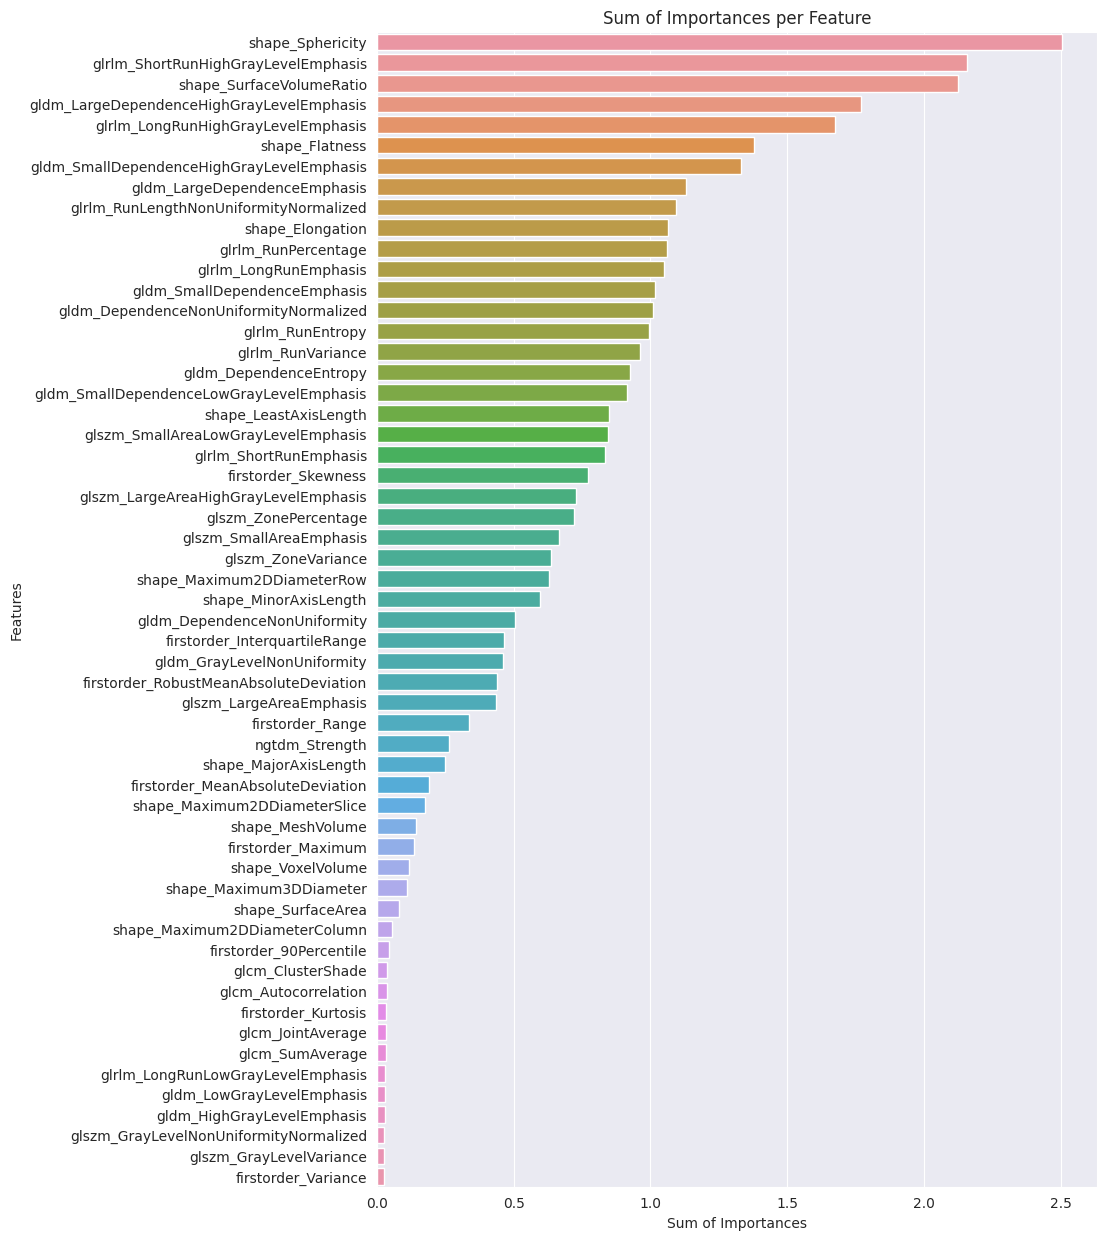

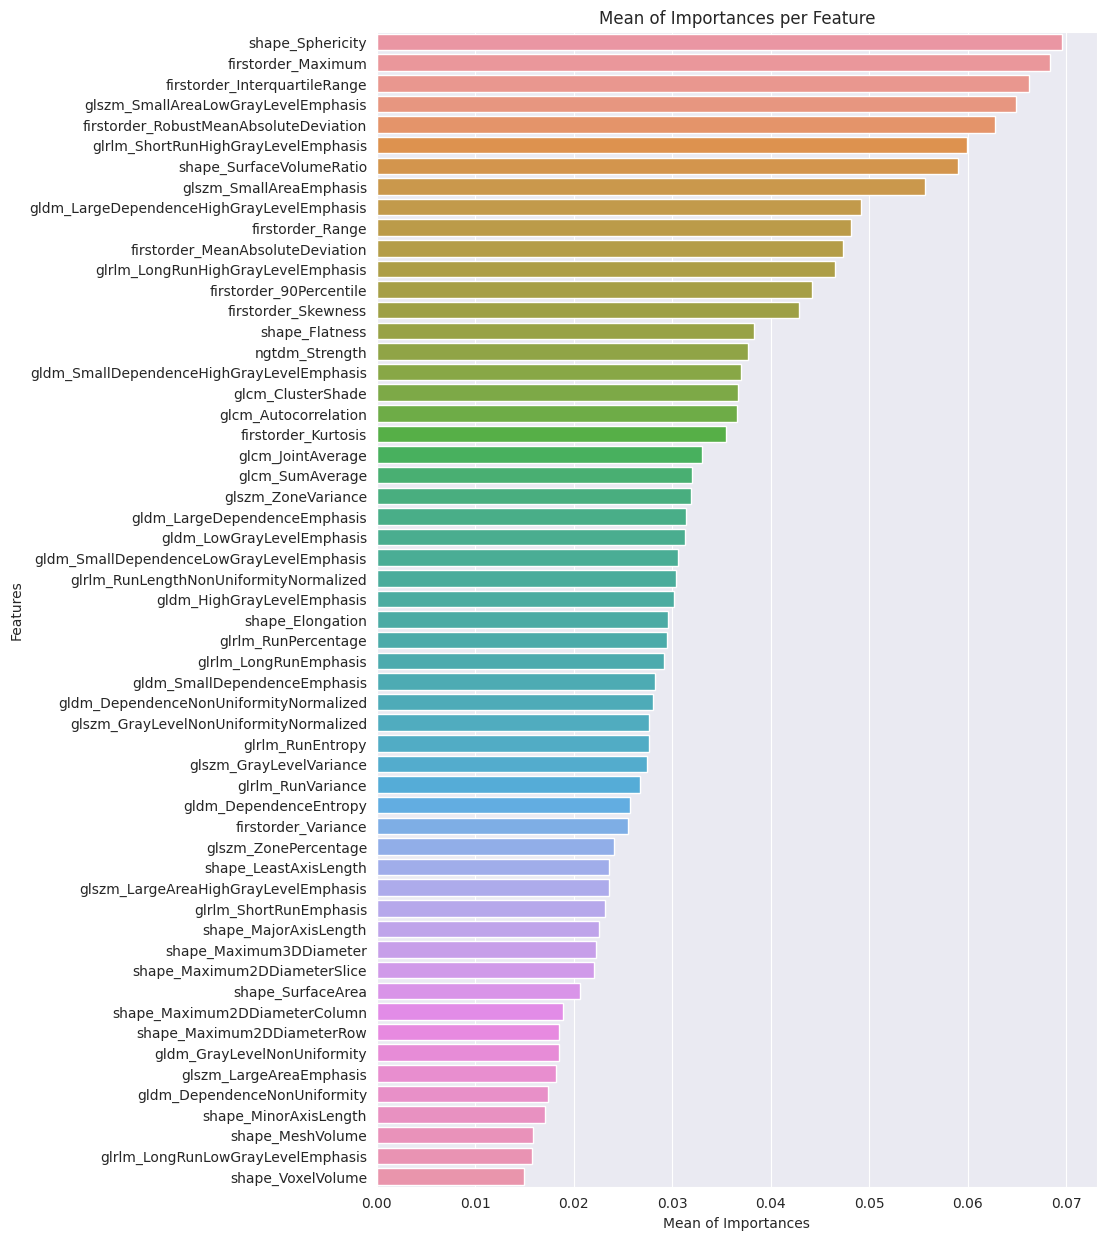

In [9]:
# Calculate the sum of importances per feature
feature_importance_sum = {}
for features, importance in best_features_RF:
    if features in feature_importance_sum:
        feature_importance_sum[features] += importance
    else:
        feature_importance_sum[features] = importance

# Convert the dictionary to lists for plotting
features = list(feature_importance_sum.keys())
importance_sum = list(feature_importance_sum.values())

# Sort the lists in descending order of importance_sum
sorted_indices = sorted(range(len(importance_sum)), key=lambda k: importance_sum[k], reverse=True)
features_sorted = [features[i] for i in sorted_indices]
importance_sum_sorted = [importance_sum[i] for i in sorted_indices]

# Plot the sum of importances per feature
plt.figure(figsize=(12, 15))
sns.barplot(x=importance_sum_sorted, y=features_sorted)
plt.xlabel('Sum of Importances')
plt.ylabel('Features')
plt.title('Sum of Importances per Feature')
plt.subplots_adjust(left=0.3)
plt.show()

feature_importance_mean = {}
feature_importance_sd = {}
feature_importance_ci = {}

for features, importance in best_features_RF:
    if features in feature_importance_mean:
        feature_importance_mean[features].append(importance)
    else:
        feature_importance_mean[features] = [importance]

feature_importance_mean_ = {feature: np.mean(importances) for feature, importances in feature_importance_mean.items()}
feature_importance_sd = {feature: np.std(importances) for feature, importances in feature_importance_mean.items()}

# Convert the dictionary to lists for plotting
features = list(feature_importance_mean_.keys())
importance_mean = list(feature_importance_mean_.values())

# Sort the lists in descending order of importance_mean
sorted_indices = sorted(range(len(importance_mean)), key=lambda k: importance_mean[k], reverse=True)
features_sorted = [features[i] for i in sorted_indices]
importance_mean_sorted = [importance_mean[i] for i in sorted_indices]

# Plot the mean of importances per feature
plt.figure(figsize=(12, 15))
sns.barplot(x=importance_mean_sorted, y=features_sorted)
plt.xlabel('Mean of Importances')
plt.ylabel('Features')
plt.title('Mean of Importances per Feature')

# Adjust the position of the figure
plt.subplots_adjust(left=0.3)

plt.show()

In [10]:
p_value_sum = {}
p_value_mean = {}
p_value_sd = {}

for p_value_dict in p_value:
    for feature, value in p_value_dict.items():
        if feature in p_value_sum:
            p_value_sum[feature] += value
        else:
            p_value_sum[feature] = value

# Calculate the mean and standard deviation of p-values per feature
for feature in p_value_sum:
    p_values_per_feature = [p_value_dict[feature] for p_value_dict in p_value if feature in p_value_dict]
    p_value_mean[feature] = np.mean(p_values_per_feature)
    p_value_sd[feature] = np.std(p_values_per_feature)

print('p_value_mean', p_value_mean)

p_value_mean {'shape_Elongation': 5.3046220023814455e-05, 'shape_Flatness': 2.4351297447469278e-05, 'shape_LeastAxisLength': 0.0023920191556815987, 'shape_Maximum2DDiameterRow': 0.003586975664891086, 'shape_Maximum2DDiameterSlice': 0.006363762903020761, 'shape_MinorAxisLength': 0.003873113147603559, 'shape_Sphericity': 1.6989878998720047e-08, 'shape_SurfaceVolumeRatio': 1.2641548606147338e-08, 'firstorder_Skewness': 0.009330970416018994, 'gldm_DependenceEntropy': 0.0010671161339604667, 'gldm_DependenceNonUniformity': 0.0064407654896953635, 'gldm_DependenceNonUniformityNormalized': 0.00024925520748372604, 'gldm_GrayLevelNonUniformity': 0.0033109490359513115, 'gldm_LargeDependenceEmphasis': 2.796487864389888e-06, 'gldm_LargeDependenceHighGrayLevelEmphasis': 7.1712495345269785e-06, 'gldm_SmallDependenceEmphasis': 0.0006259386581176366, 'gldm_SmallDependenceHighGrayLevelEmphasis': 0.00039084065056164047, 'gldm_SmallDependenceLowGrayLevelEmphasis': 0.0021087217935057854, 'glrlm_LongRunEmpha

In [11]:
print('p_value_sum', p_value_sum)

p_value_sum {'shape_Elongation': 0.00190966392085732, 'shape_Flatness': 0.0008766467081088941, 'shape_LeastAxisLength': 0.08611268960453754, 'shape_Maximum2DDiameterRow': 0.12195717260629692, 'shape_Maximum2DDiameterSlice': 0.05091010322416609, 'shape_MinorAxisLength': 0.13555896016612454, 'shape_Sphericity': 6.116356439539216e-07, 'shape_SurfaceVolumeRatio': 4.5509574982130425e-07, 'firstorder_Skewness': 0.1679574674883419, 'gldm_DependenceEntropy': 0.03841618082257679, 'gldm_DependenceNonUniformity': 0.18678219920116554, 'gldm_DependenceNonUniformityNormalized': 0.00897318746941414, 'gldm_GrayLevelNonUniformity': 0.08277372589878278, 'gldm_LargeDependenceEmphasis': 0.000100673563118036, 'gldm_LargeDependenceHighGrayLevelEmphasis': 0.00025816498324297127, 'gldm_SmallDependenceEmphasis': 0.022533791692234916, 'gldm_SmallDependenceHighGrayLevelEmphasis': 0.014070263420219057, 'gldm_SmallDependenceLowGrayLevelEmphasis': 0.06326165380517357, 'glrlm_LongRunEmphasis': 0.008213640419534323, 

In [12]:
print('p_value_sd', p_value_sd)

p_value_sd {'shape_Elongation': 0.000108500659256053, 'shape_Flatness': 5.777083728394784e-05, 'shape_LeastAxisLength': 0.0038175948236600287, 'shape_Maximum2DDiameterRow': 0.0052565058273660575, 'shape_Maximum2DDiameterSlice': 0.007990930786554626, 'shape_MinorAxisLength': 0.007320309587959363, 'shape_Sphericity': 4.711554714493575e-08, 'shape_SurfaceVolumeRatio': 2.8073867336962688e-08, 'firstorder_Skewness': 0.009360175890397872, 'gldm_DependenceEntropy': 0.002247087972484594, 'gldm_DependenceNonUniformity': 0.009029111686539196, 'gldm_DependenceNonUniformityNormalized': 0.0007094593018501348, 'gldm_GrayLevelNonUniformity': 0.0033468896113443185, 'gldm_LargeDependenceEmphasis': 4.511456376294803e-06, 'gldm_LargeDependenceHighGrayLevelEmphasis': 1.3329613007372974e-05, 'gldm_SmallDependenceEmphasis': 0.0008922220066537611, 'gldm_SmallDependenceHighGrayLevelEmphasis': 0.0005449318972468314, 'gldm_SmallDependenceLowGrayLevelEmphasis': 0.002847558900261473, 'glrlm_LongRunEmphasis': 0.00

## al my features

In [35]:
df = pd.read_excel('all_patients.xlsx')
#df = df.set_index(['subjid'])
df = df.drop('number_annotations', axis = 1)
df = df[df.shape_VoxelVolume > 125]
df.drop(df[df['labels'] == 3].index, inplace = True) ## dropping label of the call OTHERS
df = df.set_index(['subjid', 'label'])

# we select X and y
X = df.iloc[:, :-4] #leaving the sex and age features out for now
y = df.iloc[:, -1:]
X_age_sex = df.iloc[:, -4:-1]
confidence = 0.95
seed = 0

In [34]:
pipelines = {
    #'rf': imbpipeline([('smoteen', SMOTEENN(random_state=0)),
                       #('clf', RandomForestClassifier(random_state=0, class_weight="balanced"))]),
    'svc': imbpipeline([('smoteen', SMOTEENN(random_state=0)),
                        ('clf', CalibratedClassifierCV(LinearSVC(multi_class='ovr', random_state=0, class_weight="balanced")))])
    }

param_grids = {
    #'rf': {'clf__n_estimators': [100, 250, 1000, 3500]},
    'svc': {'clf__base_estimator__C': [0.1, 1, 10], 'clf__base_estimator__max_iter': [10000, 20000]}
}

cv_outer = RepeatedStratifiedKFold(n_splits=6, n_repeats=6, random_state=seed)

In [37]:
# Store the scores and metrics
scores_svc = {'acc': [], 'SD_acc': [], 'CI_acc': [], 'auc_tot': [], 'SD_auc_tot': [], 'CI_auc_tot': [], 'auc_class': [], 'SD_auc_class': [], 'CI_auc_class': [], 'Sen_mean': [], 'Sen_CI': [], 'Sen_SD': [], 'Spe_mean': [], 'Spe_CI': [], 'Spe_sd': [], 'Pre_mean': [], 'Pre_CI': [], 'Pre_sd': [], 'F1_mean': [], 'F1_CI': [], 'F1_sd': []}
#scores_svc = {'acc': [], 'SD_acc': [], 'CI_acc': [], 'auc_tot': [], 'SD_auc_tot': [], 'CI_auc_tot': [], 'auc_class': [], 'SD_auc_class': [], 'CI_auc_class': [], 'Sen_mean': [], 'Sen_CI':[], 'Sen_SD': [], 'Spe_mean': [], 'Spe_CI': [], 'Spe_sd': []}
best_features_RF = []
num_classes = len(np.unique(y))
sum_confusion_matrix_rf = np.zeros((num_classes, num_classes))
for name, pipeline in pipelines.items():
    # Initialize lists to store scores for each fold
    fold_acc = []
    fold_auc_tot = []
    fold_auc_class = []
    sensi = []
    speci = []
    prec = []
    f1 = []
    features = []
    p_value = []
    feat = []
    value = []
    for train_index, test_index in cv_outer.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        scaler = StandardScaler()
        X_train_normed = scaler.fit_transform(X_train)
        X_test_normed = scaler.transform(X_test)

        X_train_scal = pd.DataFrame(X_train_normed, columns=X_train.columns, index=X_train.index)
        X_test_scal = pd.DataFrame(X_test_normed, columns=X_test.columns, index=X_test.index)

        #select the best 15 features
        additional_columns = ['Age', 'F', 'M']
        X_train_new = X_train_scal.join(X_age_sex[additional_columns])
        X_test_new = X_test_scal.join(X_age_sex[additional_columns])

        cv_inner = RepeatedStratifiedKFold(n_splits=4, n_repeats=4, random_state=seed)
        grid_search = GridSearchCV(pipeline, param_grids[name], cv=cv_inner, scoring='roc_auc_ovr', error_score="raise")
        print(name)
        grid_search.fit(X_train_new, y_train)
        clf = grid_search.best_estimator_
        print(clf)
        clf.fit(X_train_new, y_train)
        y_pred = clf.predict(X_test_new)
        accuracy = accuracy_score(y_test, y_pred)
        num_classes = len(np.unique(y_test))
        cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
        specificity = calculate_specificity(cm)
        sensitivity = calculate_sensitivity(cm)
        precision = calculate_precision(cm)
        F1 = calculate_f1_score(cm)
        sum_confusion_matrix_rf += cm
        # Print the results

        accuracy = accuracy_score(y_test, y_pred)
        fold_acc.append(accuracy)

        # Calculate AUC score
        auc_tot = multiclass_roc_auc_score(y_test, y_pred)
        fold_auc_tot.append(auc_tot)

        auc_class = class_vs_rest_roc_auc_score(y_test, y_pred)
        fold_auc_class.append(auc_class)

        speci.append(specificity)
        sensi.append(sensitivity)
        prec.append(precision)
        f1.append(F1)

        print('Auc Score', multiclass_roc_auc_score(y_test, y_pred))
        print('Auc Score OvR', class_vs_rest_roc_auc_score(y_test, y_pred))

        if name == 'rf':
            params_rf = grid_search.best_estimator_
            feature_importance = clf.named_steps['clf'].feature_importances_
            for featureses, importance in zip(selected_feature_names, feature_importance):
                best_features_RF.append((featureses, importance))
        else:
            continue

    # Calculate average scores across folds
    if name == 'svc':
        print('mamawuevo')
        #acc
        avg_acc = np.mean(fold_acc)
        scores_svc['acc'].append(avg_acc)
        scores_svc['acc'] = scores_svc['acc'][-1]
        ci = stats.t.interval(confidence, len(fold_acc) - 1, loc=np.mean(fold_acc), scale=stats.sem(fold_acc))
        scores_svc['CI_acc'].append(ci)
        scores_svc['SD_acc'].append(np.std(fold_acc))

        #auc_tot
        avg_auc_tot = np.mean(fold_auc_tot)
        scores_svc['auc_tot'].append(avg_auc_tot)
        scores_svc['auc_tot'] = scores_svc['auc_tot'][-1]
        ci = stats.t.interval(confidence, len(fold_auc_tot) - 1, loc=np.mean(fold_auc_tot), scale=stats.sem(fold_auc_tot))
        scores_svc['CI_auc_tot'].append(ci)
        scores_svc['SD_auc_tot'].append(np.std(fold_acc))

        #auc_class
        list_0 = list(d[0] for d in fold_auc_class)
        list_1 = list(d[1] for d in fold_auc_class)
        list_2 = list(d[2] for d in fold_auc_class)

        avg_auc_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_svc['auc_class'].append(avg_auc_class)

        sd_auc_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_svc['SD_auc_class'].append(sd_auc_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_auc_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_svc['CI_auc_class'].append(CI_auc_class)

        #sensitivity
        list_0 = list(d[0] for d in sensi)
        list_1 = list(d[1] for d in sensi)
        list_2 = list(d[2] for d in sensi)

        avg_sensi_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_svc['Sen_mean'].append(avg_sensi_class)

        sd_sensi_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_svc['Sen_SD'].append(sd_sensi_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_sen_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_svc['Sen_CI'].append(CI_sen_class)

        #specificity
        list_0 = list(d[0] for d in speci)
        list_1 = list(d[1] for d in speci)
        list_2 = list(d[2] for d in speci)

        avg_speci_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_svc['Spe_mean'].append(avg_speci_class)
        sd_speci_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_svc['Spe_sd'].append(sd_speci_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_spe_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_svc['Spe_CI'].append(CI_spe_class)

        #precision
        list_0 = list(d[0] for d in prec)
        list_1 = list(d[1] for d in prec)
        list_2 = list(d[2] for d in prec)

        avg_prec_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_svc['Pre_mean'].append(avg_prec_class)
        sd_prec_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_svc['Pre_sd'].append(sd_prec_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_pre_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_svc['Pre_CI'].append(CI_pre_class)

        #F1
        list_0 = list(d[0] for d in f1)
        list_1 = list(d[1] for d in f1)
        list_2 = list(d[2] for d in f1)

        avg_f1_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_svc['F1_mean'].append(avg_f1_class)
        sd_f1_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_svc['F1_sd'].append(sd_f1_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_F1_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_svc['F1_CI'].append(CI_F1_class)


svc
Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6804952056965287
Auc Score OvR {0: 0.672077922077922, 1: 0.6091617933723197, 2: 0.7602459016393442}
svc
Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=20000,
                                                            random_state=0)))])
Auc Score 0.6904301239935408
Auc Score OvR {0: 0.6980519480519481, 1: 0.587719298245614, 2: 0.785519125683

In [38]:
for name, score in scores_svc.items():
    print('svc', f'{name}: {score}')

svc acc: 0.4737442922374431
svc SD_acc: [0.0490070500768623]
svc CI_acc: [(0.45692748033686487, 0.4905611041380213)]
svc auc_tot: 0.6721810478059754
svc SD_auc_tot: [0.0490070500768623]
svc CI_auc_tot: [(0.6559112152430437, 0.6884508803689071)]
svc auc_class: [{0: 0.6661403480433331, 1: 0.5964299543115883, 2: 0.7539728410630049}]
svc SD_auc_class: [{0: 0.1080241854078334, 1: 0.051772458117562654, 2: 0.05865406122956576}]
svc CI_auc_class: [{0: (0.6290717547722111, 0.7032089413144551), 1: (0.5786641902342138, 0.6141957183889628), 2: (0.7338456488864592, 0.7741000332395506)}]
svc Sen_mean: [{0: 59.589947089947096, 1: 38.211429458808915, 2: 79.4337606837607}]
svc Sen_CI: [{0: (52.55770504436413, 66.62218913553006), 1: (36.086659545399215, 40.336199372218616), 2: (75.23722921869502, 83.63029214882637)}]
svc Sen_SD: [{0: 20.49314936255261, 1: 6.191940907937458, 2: 12.229406434077495}]
svc Spe_mean: [{0: 73.63812251871953, 1: 81.07456140350877, 2: 71.36080752884033}]
svc Spe_CI: [{0: (71.869

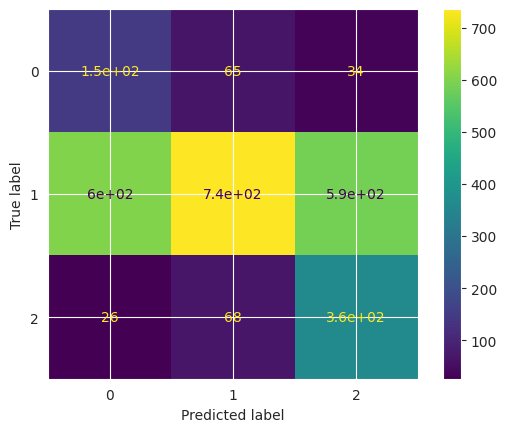

In [39]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=sum_confusion_matrix_rf,
                              display_labels=clf.classes_)
disp.plot()

plt.show()

In [40]:
sum_confusion_matrix_rf

array([[147.,  65.,  34.],
       [602., 736., 588.],
       [ 26.,  68., 362.]])